In [ ]:
%load_ext autoreload
%autoreload 2
%run denoising_diffusion_pytorch.py #used instead of importing the .ipynb as .py
%run DDRM_sampling.ipynb
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import torchvision
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
import random
import torch.nn.functional as F
from torch.nn import Sequential
import torchvision.transforms as transforms
from torch.utils.data import IterableDataset, IterDataPipe
from torchdata.datapipes.iter import Mapper, IterableWrapper
from torchdata.datapipes.iter import FileLister
from torchvision import datasets, transforms, models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import argparse
import skimage
import os
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
import glob
import pandas as pd
import csv
from scipy.stats import ks_2samp
from skimage import io
from skimage.color import rgb2gray
from torch import Tensor
from numbers import Number
from typing import Union
import torch.optim as optim
from torch.utils.data import Dataset

 Let's start with creating the dataset that will be used for the training of the DDPM classifier.

1. We need denoised images --> outputs of the reverse process as done so many times
2. And we need images of the initial galactic dataset (PROBES)

# PROBES IMAGES


# DATA PROCESSING

In [ ]:
class Galaxies(data.Dataset):

    def __init__(self, folder, image_size, minmaxnorms=(0, 5.5)):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        # fits saved as .npy files
        self.paths = list(Path(f'{folder}').glob(f'**/*.npy'))
        self.min_ = minmaxnorms[0]
        self.max_ = minmaxnorms[1]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = np.load(path)

        img = np.clip(img, self.min_, self.max_)
        img = 2*(img - self.min_)/(self.max_ - self.min_) - 1 # A min max norm for all maxima == 5 and minima == 0.0 gals

        if np.random.rand() > 0.5:
            img = np.flip(img, axis=1)
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=2)

        # Downsample of images while keeping info

        downsample = 4

        r = skimage.measure.block_reduce(img[0, :, :],
                                 (downsample, downsample),
                                 np.mean)

        g = skimage.measure.block_reduce(img[1, :, :],
                                 (downsample, downsample),
                                 np.mean)
        b = skimage.measure.block_reduce(img[2, :, :],
                                 (downsample, downsample),
                                 np.mean)

        img = np.stack((r, g, b), axis=-1)
        img = np.moveaxis(img,-1,0)
        img = img.copy()

        return torch.tensor(img)

In [ ]:
probes_dataset = Galaxies('./data/probes/', image_size=64)

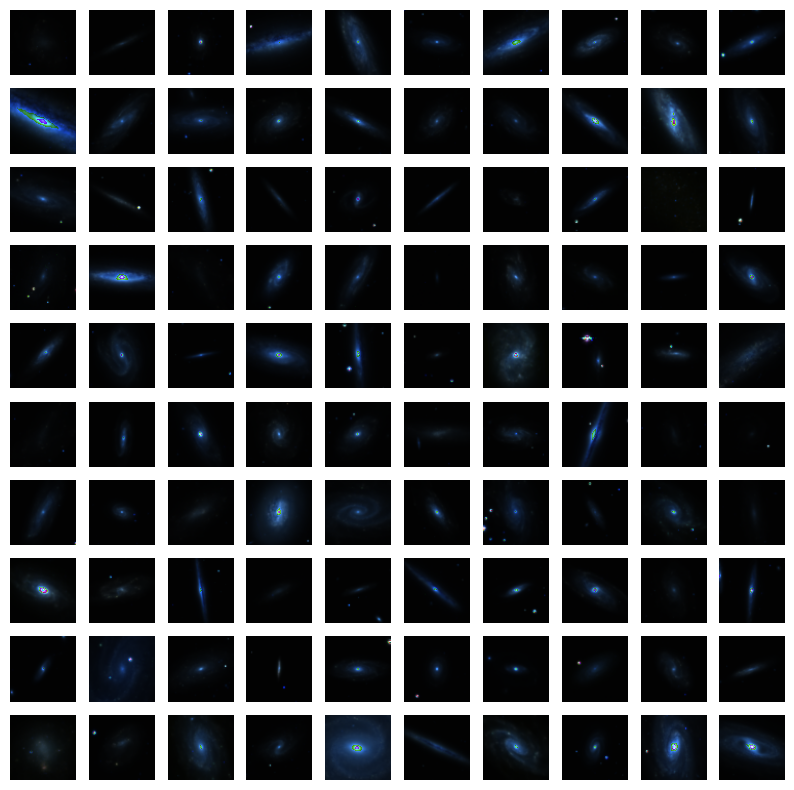

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for ax, img in zip(axs.flatten(), probes_dataset):
    img = img.numpy()
    img = np.moveaxis(img,0,-1)
    ax.imshow((img * 255).astype(np.uint8))
    ax.set_axis_off()

In [ ]:
probes_dataset = list(probes_dataset)
probes_sample = probes_dataset[0:1500]
probes_test = probes_dataset[1500:1800]
probes_sample = np.stack(probes_sample)
probes_test = np.stack(probes_test)

# Augmentation

The goal is to create let's say 9000 augmented images to compare with 9000 generated ones. So let's say we want 5 clumps of augmented images to account for the whole dataset. Augmented images that emanate from the augmentation of the downgraded probes data, the one we used to generated the DDPM samples.

In [ ]:
scale = (1,1.5)
my_trans = transforms.Compose([

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomAffine(
                degrees=(0,3),
                translate=(0.01,0.02),
                scale=(1/scale, scale) if isinstance(scale, Number) else scale,
    )])

In [ ]:
probes_dataset = probes_dataset[0:1800]
augmented = [my_trans(image) for _ in range(10) for image in probes_dataset]

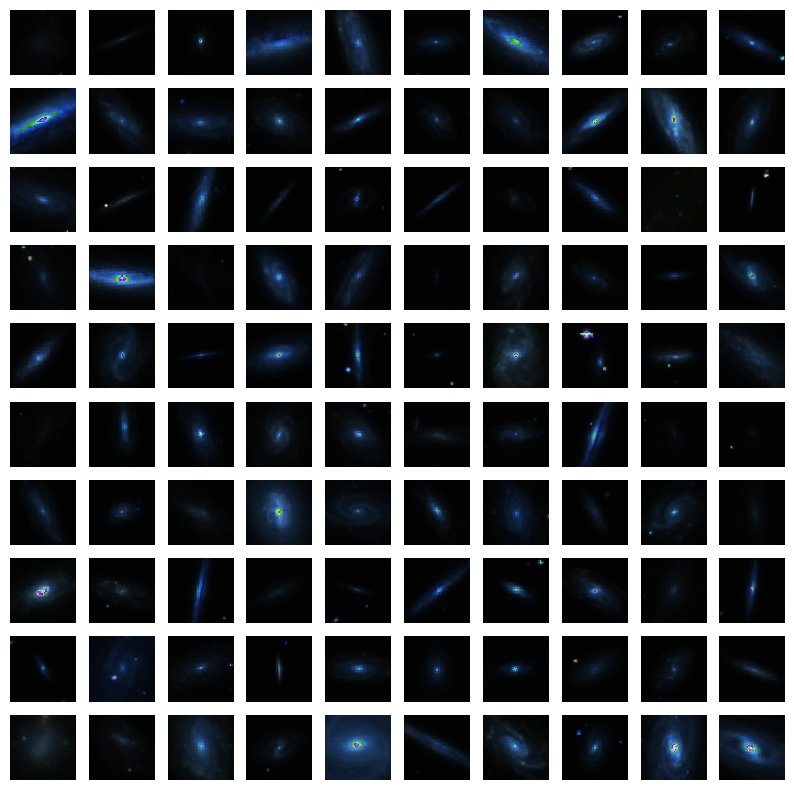

In [ ]:
# plot some augmented images to check how they look

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for ax, img in zip(axs.flatten(), augmented):
    img = img.numpy()
    img = np.moveaxis(img,0,-1)
    ax.imshow((img * 255).astype(np.uint8))
    ax.set_axis_off()

In [ ]:
augmented_train = augmented[0:16000]
augmented_test = augmented[16000:18000]

In [ ]:
type(augmented_train[0])

torch.Tensor

# How do I know if the augmentations are reasonable?

To compare the distributions of two sets of images, we can compute the mean and standard deviation of the pixel values for each set of images, and then compare these statistics. This can give us an idea of how different the pixel values are in each set of images. In our case, we could use a hypothesis test to compare the mean pixel values of the original and augmented images. For example, you could use a two-sample t-test to compare the means of the two groups. The null hypothesis is that the mean pixel values of the original and augmented images are the same. If the p-value is less than your chosen significance level (e.g., 0.05), you can reject the null hypothesis and conclude that the mean pixel values of the two groups are significantly different. If the p-value is greater than your chosen significance level, you cannot reject the null hypothesis and there is not enough evidence to conclude that the mean pixel values of the two groups are different.

# Now we need to form the DDPM samples dataset

The images trained are $3x64x64$ trained for $1300000$ steps which corresponds to $1405$ epochs based on the batch size I chose. They trained for $21969$ epochs but for $3x256x256$ images. The images were downgraded by taking the average value of multiple pixels to create one new pixel. The Gaussian diffusion was actualized wit 100 diffusion steps rather than 1000 that they did to speed up the process.

In [ ]:
path = '/home/smarkesinis/astroddpm/inferred/PROBES_2021-10-08'
all_images = glob.glob(os.path.join(path, '*.npy'))

denoised_data = []

for array in all_images:
    denoised_data.append(np.load(array))

In [ ]:
denoised_train = denoised_data[0:16000]
denoised_test = denoised_data[16000:]

16000
2000


In [ ]:
type(denoised_train[0])

numpy.ndarray

In [ ]:
# LISTS TO ARRAYS

denoised_train = np.array(denoised_train)
denoised_test = np.array(denoised_test)
augmented_train = np.stack(augmented_train)
augmented_test= np.stack(augmented_test)
augmented_train = np.array(augmented_train)
augmented_test= np.array(augmented_test)


# ARRAYS TO TENSORS

denoised_train = torch.from_numpy(denoised_train)
denoised_test = torch.from_numpy(denoised_test)
augmented_train = torch.from_numpy(augmented_train)
augmented_test = torch.from_numpy(augmented_test)


In [ ]:
# Binarizing the images

augment_data = [ [item, 0] for item in augmented_train]
denoised_data = [ [item, 1] for item in denoised_train]
augment_test_data = [ [item, 0] for item in augmented_test]
denoised_test_data = [ [item, 1] for item in denoised_test]


In [ ]:
train_data = denoised_data + augment_data
test_data = augment_test_data + denoised_test_data
train_data = random.sample(train_data,32000)
test_data = random.sample(test_data,4000)


In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [ ]:
resnet = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
#mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')

for param in mobilenet.parameters():
    param.requires_grad = False


NameError: name 'mobilenet' is not defined

In [ ]:
# DO NOT CHANGE THIS
random_seed = 1
torch.manual_seed(random_seed)

In [ ]:
# NOW WE NEED TO LOAD OUR DATASET (TRAIN AND TEST) WITH DATALOADERS.

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=True)

In [ ]:
len(test_dataloader.dataset)

4000

In [ ]:
examples = list(test_dataloader)
example_data, example_targets = examples[0]
print(example_data.shape)
print(example_targets.shape)

torch.Size([100, 3, 64, 64])
torch.Size([100])


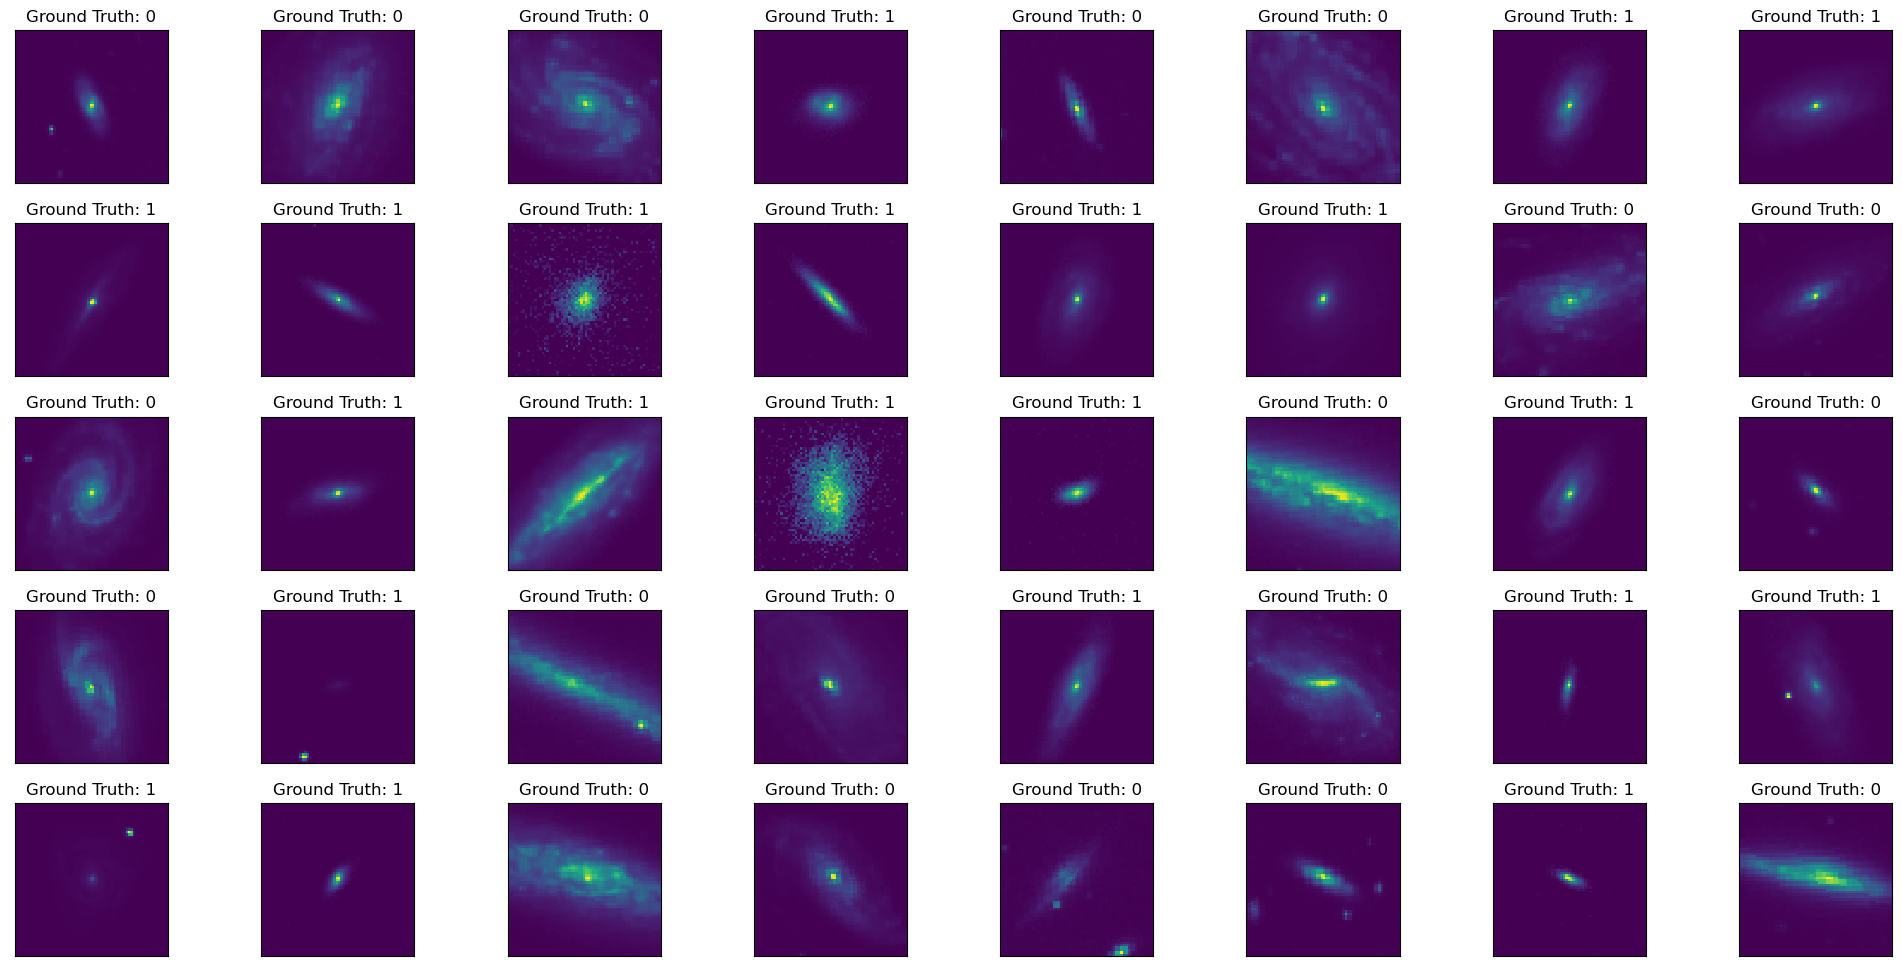

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.tight_layout()
    #print(example_data[i].shape)
    plt.imshow(example_data[i][0], interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
# Then we have to split into training and testing data and load them
# to dataloaders

# MODEL

In [ ]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 10, kernel_size=5,padding=(2,2))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5,padding=(2,2))
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5)
        self.layer_norm1 = nn.LayerNorm((10,32,32))
        self.layer_norm2 = nn.LayerNorm((40,6,6))
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1440, 500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):


        #x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv1(x),2))

        x = self.layer_norm1(x)

        x = F.relu(self.conv2(x), 2)

        x = F.max_pool2d(x,2)

        x = F.relu(F.max_pool2d(self.conv3(x),2))

        #x = F.relu(F.max_pool2d(self.conv2(x),2)
        #x = self.layer_norm2(x)




        x = self.conv2_drop(x)

        x = x.view(-1, 1440)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc3(x)

        return torch.sigmoid(x)

In [ ]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet = resnet
#         self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5,padding=(2,2))
#         self.layer_norm1 = nn.LayerNorm((10,30,30))
#         self.layer_norm2 = nn.LayerNorm((20,30,30))
#         self.conv2_drop = nn.Dropout(0.1)
#         self.fc1 = nn.Linear(4500, 1000)
        self.fc2 = nn.Linear(1000,50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):

        x = self.resnet(x)
        #print(x.shape)
        #x = F.relu(self.conv1(x))
#         x = F.max_pool2d(F.relu(self.conv1(x)),2)
#         x = self.layer_norm1(x)
#         x = F.relu(self.conv2(x))
#         x = self.layer_norm2(x)
#         x = F.max_pool2d(x,2)

        #x = F.relu(self.fc1(x))

#         x = self.conv2_drop(x)
        x = x.view(-1, 1000)
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc3(x)

        return torch.sigmoid(x)

In [ ]:
print(Classifier())

Classifier(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (layer_norm1): LayerNorm((10, 32, 32), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((40, 6, 6), eps=1e-05, elementwise_affine=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1440, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
net = Classifier()
x = torch.randn(3,64,64)
net(x).shape

torch.Size([1, 1])

In [ ]:
x = torch.randn(3,64,64)
x = x.cuda()
resnet = resnet.cuda()
net = Classifier()
net = net.to(DEVICE)
x = x.to(DEVICE)

NameError: name 'resnet' is not defined

In [ ]:
x = x.unsqueeze(0)

In [ ]:
x.shape

torch.Size([100])

In [ ]:

net(x).shape

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [100]

In [ ]:
learning_rate = 0.0001

network = Classifier().to(DEVICE)  # We move the network to the GPU
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [ ]:
n_epochs = 40  # 3 epochs by default.  Leave it like that throughout the subsequent exercises.

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(n_epochs + 1)]

In [ ]:
log_interval = 10
import matplotlib.pyplot as plt

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        #for ind, y_val in enumerate(target):
            #target[ind] = 0 if y_val < 0.5 else 1
        #print(batch_idx)
        optimizer.zero_grad()
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        output = network(data)
        output = output.flatten(0)
#         print(target.shape)
#         print(output.shape)



        loss = criterion(output,target.float())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_dataloader.dataset)))

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data,target) in enumerate(test_dataloader):

            data = data.to(DEVICE)

            target = target.to(DEVICE)

            #print(target[batch_idx].shape)
            output = network(data)
            #print(output.shape)
            output = output.flatten()
            print(output)
            #print(target)


            #print(test_loss)

            #output = torch.sigmoid(output)
            #print(output)
            #print(len(output))
            #print(output)
            test_loss += criterion(output, target.float()).item()
            #print(test_loss)
            print(len(output[output>0.5]))
            print(len(output[output<0.5]))
            output[output>0.5] =1
            output[output<=0.5] = 0

            print(output)
            print(target)
            #print(len(output==target))
            correct += (output == target).type(torch.float).sum().item()
        #print(correct)
#             if target[batch_idx].item() == 0 and output < 0.5:
#                 correct += 1

#             elif target[batch_idx].item() == 1 and output >= 0.5:

#                 wrong += 1







            #pred = (output >= 0.5).long()

            #accuracy += correct / target.shape[0]
    #print(test_loss)
    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

In [ ]:
test()

tensor([0.4730, 0.4738, 0.4731, 0.4730, 0.4730, 0.4731, 0.4731, 0.4731, 0.4731,
        0.4731, 0.4731, 0.4730, 0.4731, 0.4732, 0.4731, 0.4732, 0.4732, 0.4730,
        0.4731, 0.4731, 0.4733, 0.4733, 0.4731, 0.4734, 0.4731, 0.4731, 0.4731,
        0.4731, 0.4730, 0.4732, 0.4730, 0.4731, 0.4731, 0.4731, 0.4732, 0.4732,
        0.4743, 0.4732, 0.4731, 0.4733, 0.4731, 0.4730, 0.4733, 0.4732, 0.4732,
        0.4731, 0.4731, 0.4731, 0.4732, 0.4731, 0.4732, 0.4731, 0.4734, 0.4731,
        0.4731, 0.4729, 0.4731, 0.4731, 0.4731, 0.4731, 0.4731, 0.4731, 0.4759,
        0.4731, 0.4734, 0.4731, 0.4731, 0.4731, 0.4731, 0.4732, 0.4731, 0.4731,
        0.4732, 0.4731, 0.4732, 0.4732, 0.4731, 0.4732, 0.4732, 0.4729, 0.4731,
        0.4752, 0.4739, 0.4733, 0.4731, 0.4732, 0.4730, 0.4731, 0.4740, 0.4731,
        0.4732, 0.4731, 0.4731, 0.4732, 0.4730, 0.4731, 0.4730, 0.4731, 0.4731,
        0.4732], device='cuda:0')
0
100
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 0], device='cuda:0')

Test set: Avg. loss: 0.6947, Accuracy: 2000.0/4000 (50%)



In [ ]:
test()
for epoch in range(1, n_epochs):
    train(epoch)
    test()

tensor([0.4693, 0.4693, 0.4692, 0.4693, 0.4697, 0.4692, 0.4692, 0.4695, 0.4694,
        0.4692, 0.4692, 0.4692, 0.4692, 0.4692, 0.4693, 0.4692, 0.4694, 0.4692,
        0.4692, 0.4692, 0.4695, 0.4695, 0.4694, 0.4693, 0.4693, 0.4697, 0.4695,
        0.4692, 0.4692, 0.4692, 0.4694, 0.4693, 0.4694, 0.4692, 0.4692, 0.4695,
        0.4693, 0.4693, 0.4694, 0.4693, 0.4697, 0.4698, 0.4692, 0.4692, 0.4692,
        0.4692, 0.4692, 0.4698, 0.4696, 0.4695, 0.4695, 0.4699, 0.4692, 0.4692,
        0.4696, 0.4694, 0.4697, 0.4696, 0.4692, 0.4694, 0.4715, 0.4692, 0.4699,
        0.4692, 0.4701, 0.4700, 0.4692, 0.4694, 0.4691, 0.4692, 0.4693, 0.4690,
        0.4693, 0.4693, 0.4697, 0.4693, 0.4703, 0.4693, 0.4693, 0.4692, 0.4694,
        0.4692, 0.4692, 0.4703, 0.4692, 0.4697, 0.4699, 0.4692, 0.4692, 0.4699,
        0.4693, 0.4695, 0.4692, 0.4692, 0.4701, 0.4695, 0.4691, 0.4706, 0.4700,
        0.4691], device='cuda:0')
0
100
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 0], device='cuda:0')

Test set: Avg. loss: 0.6952, Accuracy: 2000.0/4000 (50%)

Train Epoch: 1 [0/32000 (0%)]	Loss: 0.693109
Train Epoch: 1 [640/32000 (2%)]	Loss: 0.688789
Train Epoch: 1 [1280/32000 (4%)]	Loss: 0.695882
Train Epoch: 1 [1920/32000 (6%)]	Loss: 0.695414
Train Epoch: 1 [2560/32000 (8%)]	Loss: 0.695201
Train Epoch: 1 [3200/32000 (10%)]	Loss: 0.688443
Train Epoch: 1 [3840/32000 (12%)]	Loss: 0.690369
Train Epoch: 1 [4480/32000 (14%)]	Loss: 0.691142
Train Epoch: 1 [5120/32000 (16%)]	Loss: 0.684340
Train Epoch: 1 [5760/32000 (18%)]	Loss: 0.690832
Train Epoch: 1 [6400/32000 (20%)]	Loss: 0.689201
Train Epoch: 1 [7040/32000 (22%)]	Loss: 0.676336
Trai

tensor([0.9021, 0.6903, 0.5258, 0.8619, 0.8167, 0.1620, 0.2924, 0.7296, 0.6428,
        0.7413, 0.0714, 0.7047, 0.4454, 0.3329, 0.7631, 0.0912, 0.6539, 0.6818,
        0.3306, 0.1831, 0.2245, 0.3703, 0.5966, 0.6567, 0.5486, 0.6478, 0.7467,
        0.2550, 0.4437, 0.1479, 0.8089, 0.6874, 0.2210, 0.9362, 0.7409, 0.0840,
        0.7568, 0.6427, 0.5340, 0.1840, 0.1672, 0.8599, 0.3141, 0.7726, 0.7887,
        0.0590, 0.1747, 0.1275, 0.8310, 0.2752, 0.2350, 0.0922, 0.4274, 0.2889,
        0.7700, 0.4386, 0.7669, 0.7407, 0.1137, 0.2295, 0.6285, 0.3473, 0.3123,
        0.8095, 0.3938, 0.4258, 0.2601, 0.6779, 0.5905, 0.7086, 0.8391, 0.3790,
        0.6715, 0.3204, 0.1720, 0.6829, 0.9044, 0.7559, 0.8992, 0.1440, 0.5936,
        0.7613, 0.6054, 0.2305, 0.7542, 0.8941, 0.1432, 0.2307, 0.1057, 0.1550,
        0.1662, 0.1630, 0.6916, 0.1421, 0.8034, 0.9483, 0.4023, 0.0700, 0.7421,
        0.0843], device='cuda:0')
51
49
tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.,


Train Epoch: 2 [1280/32000 (4%)]	Loss: 0.436709
Train Epoch: 2 [1920/32000 (6%)]	Loss: 0.508058
Train Epoch: 2 [2560/32000 (8%)]	Loss: 0.533080
Train Epoch: 2 [3200/32000 (10%)]	Loss: 0.525915
Train Epoch: 2 [3840/32000 (12%)]	Loss: 0.486790
Train Epoch: 2 [4480/32000 (14%)]	Loss: 0.453411
Train Epoch: 2 [5120/32000 (16%)]	Loss: 0.399759
Train Epoch: 2 [5760/32000 (18%)]	Loss: 0.555730
Train Epoch: 2 [6400/32000 (20%)]	Loss: 0.473707
Train Epoch: 2 [7040/32000 (22%)]	Loss: 0.433749
Train Epoch: 2 [7680/32000 (24%)]	Loss: 0.401756
Train Epoch: 2 [8320/32000 (26%)]	Loss: 0.415684
Train Epoch: 2 [8960/32000 (28%)]	Loss: 0.390439
Train Epoch: 2 [9600/32000 (30%)]	Loss: 0.371491
Train Epoch: 2 [10240/32000 (32%)]	Loss: 0.379063
Train Epoch: 2 [10880/32000 (34%)]	Loss: 0.468449
Train Epoch: 2 [11520/32000 (36%)]	Loss: 0.403627
Train Epoch: 2 [12160/32000 (38%)]	Loss: 0.431959
Train Epoch: 2 [12800/32000 (40%)]	Loss: 0.417488
Train Epoch: 2 [13440/32000 (42%)]	Loss: 0.492361
Train Epoch: 2 [1

tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 1.], device='cuda:0')
tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1], device='cuda:0')
tensor([0.0662, 0.0127, 0.1148, 0.0262, 0.1902, 0.0070, 0.9837, 0.9548, 0.7810,
        0.9071, 0.0271, 0.7932, 0.0271, 0.7676, 0.9476, 0.6533, 0.3684, 0.7441,
        0.9301, 

Train Epoch: 3 [2560/32000 (8%)]	Loss: 0.311857
Train Epoch: 3 [3200/32000 (10%)]	Loss: 0.366247
Train Epoch: 3 [3840/32000 (12%)]	Loss: 0.310636
Train Epoch: 3 [4480/32000 (14%)]	Loss: 0.358016
Train Epoch: 3 [5120/32000 (16%)]	Loss: 0.575095
Train Epoch: 3 [5760/32000 (18%)]	Loss: 0.373919
Train Epoch: 3 [6400/32000 (20%)]	Loss: 0.221721
Train Epoch: 3 [7040/32000 (22%)]	Loss: 0.477947
Train Epoch: 3 [7680/32000 (24%)]	Loss: 0.238363
Train Epoch: 3 [8320/32000 (26%)]	Loss: 0.325350
Train Epoch: 3 [8960/32000 (28%)]	Loss: 0.264750
Train Epoch: 3 [9600/32000 (30%)]	Loss: 0.276246
Train Epoch: 3 [10240/32000 (32%)]	Loss: 0.394487
Train Epoch: 3 [10880/32000 (34%)]	Loss: 0.308232
Train Epoch: 3 [11520/32000 (36%)]	Loss: 0.335724
Train Epoch: 3 [12160/32000 (38%)]	Loss: 0.223297
Train Epoch: 3 [12800/32000 (40%)]	Loss: 0.308342
Train Epoch: 3 [13440/32000 (42%)]	Loss: 0.252614
Train Epoch: 3 [14080/32000 (44%)]	Loss: 0.321432
Train Epoch: 3 [14720/32000 (46%)]	Loss: 0.337539
Train Epoch: 

tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1], device='cuda:0')
tensor([0.0893, 0.1349, 0.2488, 0.2666, 0.9575, 0.0407, 0.0259, 0.9024, 0.1706,
        0.9664, 0.7171, 0.0452, 0.0044, 0.1373, 0.0012, 0.8912, 0.0127, 0.0077,
        0.9000, 0.9782, 0.0293, 0.9326, 0.0074, 0.9660, 0.7249, 0.7435, 0.7743,
        0.8770, 0.7447, 0.6228, 0.0235, 0.0058, 0.9779, 0.0029, 0.2010, 0.8283,
        0.5166, 0.0502, 0.9871, 0.4899, 0.0150, 0.5730, 0.8476, 0.0906, 0.0499,
        0.3129, 0.8637, 0.9798, 0.9005, 0.0271, 0.0151, 0.4778, 0.8794, 0.7048,
        0.9763, 0.9874, 0.9853, 0.9056, 0.9665, 0.0388, 0.2922, 0.0469, 0.9447,
        0.8396, 0.7657, 0.2172, 0.0176, 0.9675, 0.0336, 0.1717, 0.0523, 0.0622,
  

Train Epoch: 4 [0/32000 (0%)]	Loss: 0.316173
Train Epoch: 4 [640/32000 (2%)]	Loss: 0.328767
Train Epoch: 4 [1280/32000 (4%)]	Loss: 0.167020
Train Epoch: 4 [1920/32000 (6%)]	Loss: 0.308300
Train Epoch: 4 [2560/32000 (8%)]	Loss: 0.397658
Train Epoch: 4 [3200/32000 (10%)]	Loss: 0.208668
Train Epoch: 4 [3840/32000 (12%)]	Loss: 0.198367
Train Epoch: 4 [4480/32000 (14%)]	Loss: 0.240238
Train Epoch: 4 [5120/32000 (16%)]	Loss: 0.258687
Train Epoch: 4 [5760/32000 (18%)]	Loss: 0.301333
Train Epoch: 4 [6400/32000 (20%)]	Loss: 0.287483
Train Epoch: 4 [7040/32000 (22%)]	Loss: 0.197372
Train Epoch: 4 [7680/32000 (24%)]	Loss: 0.370580
Train Epoch: 4 [8320/32000 (26%)]	Loss: 0.274595
Train Epoch: 4 [8960/32000 (28%)]	Loss: 0.390341
Train Epoch: 4 [9600/32000 (30%)]	Loss: 0.222198
Train Epoch: 4 [10240/32000 (32%)]	Loss: 0.239162
Train Epoch: 4 [10880/32000 (34%)]	Loss: 0.469192
Train Epoch: 4 [11520/32000 (36%)]	Loss: 0.272688
Train Epoch: 4 [12160/32000 (38%)]	Loss: 0.264540
Train Epoch: 4 [12800/320

tensor([0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1.], device='cuda:0')
tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1], device='cuda:0')
tensor([9.9095e-01, 8.7391e-01, 7.5954e-01, 9.7675e-01, 9.8113e-01, 4.8664e-02,
        1.8551e-02, 1.2534e-01, 4.2795e-03, 8.9001e-01, 1.2151e-02, 2.9352e-02,
        1.2720e-

Train Epoch: 5 [1280/32000 (4%)]	Loss: 0.248278
Train Epoch: 5 [1920/32000 (6%)]	Loss: 0.236354
Train Epoch: 5 [2560/32000 (8%)]	Loss: 0.180207
Train Epoch: 5 [3200/32000 (10%)]	Loss: 0.160508
Train Epoch: 5 [3840/32000 (12%)]	Loss: 0.266968
Train Epoch: 5 [4480/32000 (14%)]	Loss: 0.202133
Train Epoch: 5 [5120/32000 (16%)]	Loss: 0.194672
Train Epoch: 5 [5760/32000 (18%)]	Loss: 0.166882
Train Epoch: 5 [6400/32000 (20%)]	Loss: 0.320961
Train Epoch: 5 [7040/32000 (22%)]	Loss: 0.255550
Train Epoch: 5 [7680/32000 (24%)]	Loss: 0.259356
Train Epoch: 5 [8320/32000 (26%)]	Loss: 0.343096
Train Epoch: 5 [8960/32000 (28%)]	Loss: 0.165777
Train Epoch: 5 [9600/32000 (30%)]	Loss: 0.149889
Train Epoch: 5 [10240/32000 (32%)]	Loss: 0.275612
Train Epoch: 5 [10880/32000 (34%)]	Loss: 0.343550
Train Epoch: 5 [11520/32000 (36%)]	Loss: 0.207765
Train Epoch: 5 [12160/32000 (38%)]	Loss: 0.189747
Train Epoch: 5 [12800/32000 (40%)]	Loss: 0.306762
Train Epoch: 5 [13440/32000 (42%)]	Loss: 0.268865
Train Epoch: 5 [1

tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 0], device='cuda:0')
tensor([0.1986, 0.0088, 0.0577, 0.9630, 0.0065, 0.0369, 0.8289, 0.9917, 0.9568,
        0.0570, 0.9682, 0.9886, 0.9313, 0.9865, 0.9600, 0.0157, 0.9815, 0.3742,
        0.9770, 0.2978, 0.0139, 0.2526, 0.4458, 0.9856, 0.0165, 0.3609, 0.0221,
        0.9852, 0.7040, 0.9570, 0.9813, 0.0111, 0.0273, 0.0981, 0.9624, 0.7040,
        0.0245, 0.8164, 0.7669, 0.9732, 0.0185, 0.9308, 0.1399, 0.9874, 0.2760,
        0.0295, 0.9753, 0.0189, 0.0324, 0.9556, 0.5266, 0.9965, 0.9698, 0.0040,
        0.1270, 0.9823, 0.0830, 0.0269, 0.2226, 0.9873, 0.3687, 0.0765, 0.2269,
        0.9624, 0.9805, 0.9209, 0.9243, 0.0295, 0.5581, 0.9612, 0.0506, 0.9793,
  

Train Epoch: 6 [2560/32000 (8%)]	Loss: 0.177170
Train Epoch: 6 [3200/32000 (10%)]	Loss: 0.295321
Train Epoch: 6 [3840/32000 (12%)]	Loss: 0.182854
Train Epoch: 6 [4480/32000 (14%)]	Loss: 0.283730
Train Epoch: 6 [5120/32000 (16%)]	Loss: 0.164598
Train Epoch: 6 [5760/32000 (18%)]	Loss: 0.169476
Train Epoch: 6 [6400/32000 (20%)]	Loss: 0.283166
Train Epoch: 6 [7040/32000 (22%)]	Loss: 0.233840
Train Epoch: 6 [7680/32000 (24%)]	Loss: 0.200620
Train Epoch: 6 [8320/32000 (26%)]	Loss: 0.256684
Train Epoch: 6 [8960/32000 (28%)]	Loss: 0.353551
Train Epoch: 6 [9600/32000 (30%)]	Loss: 0.151531
Train Epoch: 6 [10240/32000 (32%)]	Loss: 0.252492
Train Epoch: 6 [10880/32000 (34%)]	Loss: 0.356020
Train Epoch: 6 [11520/32000 (36%)]	Loss: 0.132831
Train Epoch: 6 [12160/32000 (38%)]	Loss: 0.181859
Train Epoch: 6 [12800/32000 (40%)]	Loss: 0.340250
Train Epoch: 6 [13440/32000 (42%)]	Loss: 0.171679
Train Epoch: 6 [14080/32000 (44%)]	Loss: 0.264638
Train Epoch: 6 [14720/32000 (46%)]	Loss: 0.185122
Train Epoch: 

tensor([7.6158e-03, 1.6650e-02, 3.0137e-02, 2.7061e-02, 4.2548e-02, 2.7906e-02,
        9.8934e-01, 4.4657e-02, 9.4444e-01, 9.7406e-01, 4.2286e-03, 5.1510e-02,
        9.9058e-01, 9.8002e-01, 1.2248e-02, 8.7745e-01, 8.0772e-02, 1.5709e-01,
        1.6121e-02, 9.9396e-01, 9.8979e-01, 9.5051e-01, 2.0408e-03, 2.2582e-02,
        9.4293e-01, 9.8848e-01, 3.0812e-03, 2.0504e-03, 8.9654e-01, 8.3135e-01,
        9.9540e-01, 8.2014e-03, 1.2163e-02, 4.0219e-03, 9.7347e-01, 2.5685e-02,
        9.9020e-01, 1.9119e-02, 8.9464e-02, 8.1527e-04, 8.9463e-03, 1.3479e-01,
        9.7553e-01, 9.8300e-01, 1.5801e-02, 9.8932e-01, 8.1772e-01, 9.7454e-01,
        5.7918e-01, 9.9094e-01, 4.4085e-01, 1.2773e-02, 1.6860e-02, 9.0354e-02,
        8.6422e-01, 1.9402e-03, 9.9215e-01, 8.0291e-01, 1.8837e-02, 7.0120e-01,
        7.9144e-01, 5.1859e-01, 8.2391e-01, 4.9713e-04, 1.2157e-02, 7.3266e-03,
        3.8315e-02, 7.2838e-02, 8.1036e-01, 1.9891e-02, 4.5215e-02, 9.9689e-01,
        1.2156e-01, 9.4977e-01, 7.1913e-

tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1], device='cuda:0')
tensor([7.7279e-03, 9.7172e-01, 9.4476e-01, 1.2207e-02, 4.2713e-01, 1.6697e-02,
        7.8549e-01, 7.4593e-01, 1.0079e-02, 2.4367e-01, 3.7725e-02, 4.4763e-01,
        7.9046e-03, 1.2229e-02, 3.3329e-02, 9.7795e-01, 9.9303e-01, 8.9627e-01,
        9.7126e-01, 9.9336e-01, 2.5788e-02, 9.6274e-01, 9.5906e-01, 9.8458e-01,
        4.3868e-02, 4.3996e-01, 9.9178e-01, 6.0546e-01, 3.8084e-03, 9.2920e-01,
        6.8562e-01, 8.7338e-01, 2.4998e-02, 5.1783e-03, 9.9232e-01, 4.9344e-02,
        9.7462e-01, 3.0410e-03, 4.4007e-01, 3.6371e-02, 7.6375e-03, 3.0277e-02,
        4.2354e-01, 9.7665e-01, 9.4033e-01, 4.1733e-02, 8.6223e-01, 1.2855e-02,
  

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0], device='cuda:0')
tensor([9.7642e-01, 9.3975e-01, 7.7735e-01, 9.7734e-01, 9.4677e-01, 8.9718e-01,
        9.4838e-03, 1.2953e-02, 1.2096e-02, 2.5586e-02, 9.4891e-01, 5.1757e-03,
        9.8586e-03, 9.3794e-01, 7.3242e-03, 5.8934e-01, 6.2256e-01, 3.6184e-01,
        1.0044e-02, 5.7794e-03, 1.1143e-02, 7.9568e-01, 6.6349e-03, 9.2982e-01,
        7.4472e-03, 1.8376e-02, 8.7120e-01, 1.2031e-02, 4.8227e-03, 9.7205e-01,
        8.9218e-03, 6.8076e-01, 1.5521e-01, 9.4817e-01, 2.7745e-03, 9.0930e-03,
        3.0530e-01, 7.7915e-01, 8.8070e-02, 5.1601e-01, 3.2737e-01, 4.7194e-01,
        9.8845e-03, 1.9877e-02, 1.1879e-02, 6.6487e-01, 3.6694e-03, 7.7960e-01,
  

Train Epoch: 8 [1280/32000 (4%)]	Loss: 0.181127
Train Epoch: 8 [1920/32000 (6%)]	Loss: 0.150969
Train Epoch: 8 [2560/32000 (8%)]	Loss: 0.190137
Train Epoch: 8 [3200/32000 (10%)]	Loss: 0.186986
Train Epoch: 8 [3840/32000 (12%)]	Loss: 0.086801
Train Epoch: 8 [4480/32000 (14%)]	Loss: 0.174452
Train Epoch: 8 [5120/32000 (16%)]	Loss: 0.237421
Train Epoch: 8 [5760/32000 (18%)]	Loss: 0.234410
Train Epoch: 8 [6400/32000 (20%)]	Loss: 0.178526
Train Epoch: 8 [7040/32000 (22%)]	Loss: 0.217400
Train Epoch: 8 [7680/32000 (24%)]	Loss: 0.092578
Train Epoch: 8 [8320/32000 (26%)]	Loss: 0.302512
Train Epoch: 8 [8960/32000 (28%)]	Loss: 0.086405
Train Epoch: 8 [9600/32000 (30%)]	Loss: 0.195675
Train Epoch: 8 [10240/32000 (32%)]	Loss: 0.189351
Train Epoch: 8 [10880/32000 (34%)]	Loss: 0.193469
Train Epoch: 8 [11520/32000 (36%)]	Loss: 0.115097
Train Epoch: 8 [12160/32000 (38%)]	Loss: 0.105027
Train Epoch: 8 [12800/32000 (40%)]	Loss: 0.107879
Train Epoch: 8 [13440/32000 (42%)]	Loss: 0.141458
Train Epoch: 8 [1

tensor([9.9306e-01, 9.8412e-01, 9.9657e-01, 6.4019e-01, 9.9759e-01, 9.8122e-04,
        7.1781e-04, 6.5412e-04, 3.3910e-03, 7.6728e-03, 3.1907e-03, 9.9064e-03,
        2.3741e-03, 8.8041e-01, 9.8999e-01, 9.5242e-01, 2.3240e-03, 5.0836e-03,
        5.3936e-01, 9.8047e-01, 6.8227e-03, 1.9681e-01, 9.6883e-01, 9.9299e-01,
        9.9339e-01, 3.1108e-03, 9.6908e-01, 9.7886e-01, 9.9574e-01, 8.5285e-01,
        9.7582e-01, 8.9709e-01, 2.2908e-03, 9.8357e-01, 9.8807e-01, 1.0562e-02,
        2.1572e-01, 9.8681e-01, 9.4373e-01, 3.1850e-02, 6.3825e-01, 6.4288e-03,
        9.8695e-01, 8.5205e-01, 8.1485e-01, 6.6199e-02, 9.9267e-01, 2.8104e-02,
        7.1712e-01, 6.8758e-03, 8.1133e-01, 4.0719e-03, 9.7611e-01, 9.9442e-01,
        1.4222e-02, 2.1867e-02, 9.4453e-01, 1.0379e-02, 9.3186e-01, 1.0547e-02,
        9.8058e-01, 9.7217e-01, 9.5264e-01, 3.7086e-02, 9.9732e-01, 7.7754e-01,
        1.1278e-01, 1.3249e-02, 2.2774e-01, 1.5662e-01, 8.8479e-01, 2.9945e-04,
        9.5988e-01, 3.2839e-01, 9.6223e-

Train Epoch: 9 [2560/32000 (8%)]	Loss: 0.172814
Train Epoch: 9 [3200/32000 (10%)]	Loss: 0.228661
Train Epoch: 9 [3840/32000 (12%)]	Loss: 0.171552
Train Epoch: 9 [4480/32000 (14%)]	Loss: 0.127673
Train Epoch: 9 [5120/32000 (16%)]	Loss: 0.177422
Train Epoch: 9 [5760/32000 (18%)]	Loss: 0.135925
Train Epoch: 9 [6400/32000 (20%)]	Loss: 0.200076
Train Epoch: 9 [7040/32000 (22%)]	Loss: 0.165653
Train Epoch: 9 [7680/32000 (24%)]	Loss: 0.072339
Train Epoch: 9 [8320/32000 (26%)]	Loss: 0.065500
Train Epoch: 9 [8960/32000 (28%)]	Loss: 0.165866
Train Epoch: 9 [9600/32000 (30%)]	Loss: 0.113373
Train Epoch: 9 [10240/32000 (32%)]	Loss: 0.176923
Train Epoch: 9 [10880/32000 (34%)]	Loss: 0.238191
Train Epoch: 9 [11520/32000 (36%)]	Loss: 0.246116
Train Epoch: 9 [12160/32000 (38%)]	Loss: 0.096888
Train Epoch: 9 [12800/32000 (40%)]	Loss: 0.056398
Train Epoch: 9 [13440/32000 (42%)]	Loss: 0.114411
Train Epoch: 9 [14080/32000 (44%)]	Loss: 0.181419
Train Epoch: 9 [14720/32000 (46%)]	Loss: 0.061589
Train Epoch: 

tensor([9.1866e-01, 9.6616e-01, 9.3117e-01, 7.1550e-03, 9.5194e-01, 7.3299e-03,
        1.5200e-02, 7.5971e-04, 9.5788e-01, 9.9736e-01, 3.0666e-03, 9.7918e-01,
        8.5292e-02, 3.8558e-03, 2.3023e-02, 9.3966e-01, 9.9055e-01, 1.8932e-01,
        9.9280e-01, 9.9629e-01, 9.9874e-01, 3.4140e-04, 7.5850e-03, 3.4828e-02,
        9.2718e-01, 9.8307e-01, 4.5472e-01, 9.5379e-01, 2.5348e-01, 9.9234e-01,
        8.7780e-01, 4.4684e-02, 9.5504e-01, 9.9015e-01, 5.7230e-03, 9.9758e-01,
        1.8077e-04, 9.9737e-01, 9.9675e-01, 2.9259e-03, 4.1147e-03, 3.4677e-03,
        9.5915e-03, 3.1000e-03, 2.7564e-01, 9.8339e-01, 9.9764e-01, 9.0425e-01,
        1.3079e-01, 9.8534e-01, 7.6513e-03, 9.6941e-01, 9.8333e-01, 5.5537e-03,
        9.9395e-01, 9.2203e-01, 9.5043e-01, 2.8736e-03, 2.3573e-02, 1.4434e-03,
        9.6924e-01, 9.6140e-01, 4.7816e-02, 9.1279e-01, 9.9375e-01, 9.8771e-01,
        9.6794e-01, 9.9878e-01, 9.0011e-03, 7.6263e-01, 7.9734e-01, 9.8329e-01,
        9.9044e-01, 9.2812e-01, 9.8830e-

tensor([3.6406e-03, 8.4809e-01, 9.8072e-01, 9.9614e-01, 9.8775e-01, 9.8205e-01,
        7.3030e-01, 3.2336e-02, 9.7562e-01, 2.6840e-01, 9.6418e-02, 9.9814e-01,
        2.0967e-03, 9.8969e-01, 9.7755e-01, 2.0024e-01, 5.4014e-03, 9.9784e-01,
        9.7040e-01, 4.7470e-03, 8.8115e-01, 9.6554e-01, 5.4030e-01, 6.2375e-02,
        8.3380e-01, 9.9197e-01, 9.9933e-01, 6.5507e-04, 8.4896e-04, 4.5105e-03,
        9.9850e-01, 5.6705e-02, 6.3444e-01, 9.9503e-01, 2.8825e-03, 9.6959e-01,
        9.1275e-04, 5.6550e-04, 9.8737e-01, 4.4685e-02, 9.9132e-01, 9.8584e-01,
        9.6658e-01, 9.9166e-01, 3.7735e-03, 9.3181e-01, 9.9670e-01, 8.5426e-01,
        2.6764e-01, 9.6670e-01, 8.6113e-04, 2.9228e-03, 9.7486e-01, 2.8426e-04,
        2.6314e-02, 5.8117e-02, 9.9612e-01, 1.5862e-01, 9.4386e-01, 9.9738e-01,
        9.1141e-01, 3.2515e-03, 9.9541e-01, 1.3126e-02, 9.8720e-01, 1.2018e-03,
        9.9664e-01, 7.9766e-03, 5.0319e-01, 9.9474e-01, 9.0683e-01, 9.9472e-01,
        8.8369e-01, 2.9813e-03, 9.8518e-

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 1], device='cuda:0')
tensor([1.4973e-01, 1.5338e-01, 1.1771e-03, 1.9980e-02, 4.4548e-03, 4.1278e-01,
        7.7894e-01, 1.4871e-02, 9.3017e-01, 2.5021e-03, 9.8013e-01, 6.1438e-03,
        9.7726e-

Train Epoch: 11 [1280/32000 (4%)]	Loss: 0.102412
Train Epoch: 11 [1920/32000 (6%)]	Loss: 0.289870
Train Epoch: 11 [2560/32000 (8%)]	Loss: 0.095259
Train Epoch: 11 [3200/32000 (10%)]	Loss: 0.094502
Train Epoch: 11 [3840/32000 (12%)]	Loss: 0.068413
Train Epoch: 11 [4480/32000 (14%)]	Loss: 0.181003
Train Epoch: 11 [5120/32000 (16%)]	Loss: 0.082322
Train Epoch: 11 [5760/32000 (18%)]	Loss: 0.123438
Train Epoch: 11 [6400/32000 (20%)]	Loss: 0.096765
Train Epoch: 11 [7040/32000 (22%)]	Loss: 0.167988
Train Epoch: 11 [7680/32000 (24%)]	Loss: 0.151720
Train Epoch: 11 [8320/32000 (26%)]	Loss: 0.174380
Train Epoch: 11 [8960/32000 (28%)]	Loss: 0.140410
Train Epoch: 11 [9600/32000 (30%)]	Loss: 0.099056
Train Epoch: 11 [10240/32000 (32%)]	Loss: 0.079935
Train Epoch: 11 [10880/32000 (34%)]	Loss: 0.094900
Train Epoch: 11 [11520/32000 (36%)]	Loss: 0.082781
Train Epoch: 11 [12160/32000 (38%)]	Loss: 0.179141
Train Epoch: 11 [12800/32000 (40%)]	Loss: 0.061630
Train Epoch: 11 [13440/32000 (42%)]	Loss: 0.1119

tensor([2.0619e-02, 2.6411e-04, 7.1739e-05, 2.7623e-03, 6.7087e-01, 4.9082e-04,
        9.7784e-01, 9.9610e-01, 7.1451e-01, 9.7328e-01, 3.0590e-02, 2.2938e-03,
        9.1293e-01, 9.1379e-01, 9.8171e-01, 5.0155e-02, 1.7534e-02, 1.1575e-02,
        9.9701e-01, 9.9278e-01, 9.7625e-01, 9.0590e-01, 9.9128e-01, 1.3210e-03,
        9.9698e-01, 9.9896e-01, 5.6027e-06, 9.8511e-01, 9.3997e-01, 8.7491e-04,
        2.3115e-01, 9.9747e-01, 3.0470e-03, 2.0557e-04, 9.8788e-01, 9.8014e-01,
        3.0663e-04, 9.7441e-01, 9.9243e-01, 9.9443e-01, 9.7254e-01, 9.9160e-01,
        9.9712e-01, 7.4888e-01, 9.9758e-01, 9.9827e-01, 9.5035e-01, 8.8770e-01,
        2.6397e-03, 1.4302e-05, 9.8574e-01, 8.5073e-04, 4.5309e-01, 9.9921e-01,
        4.4951e-04, 1.0314e-03, 6.6074e-05, 1.6637e-02, 9.1189e-01, 1.6877e-02,
        1.1374e-03, 9.5071e-01, 9.8160e-05, 9.3417e-02, 2.8632e-04, 1.4956e-03,
        5.2893e-03, 1.1107e-03, 2.9001e-01, 9.9712e-01, 3.4162e-04, 9.9476e-01,
        9.9673e-01, 9.9757e-01, 2.3321e-

Train Epoch: 12 [2560/32000 (8%)]	Loss: 0.191326
Train Epoch: 12 [3200/32000 (10%)]	Loss: 0.295351
Train Epoch: 12 [3840/32000 (12%)]	Loss: 0.060880
Train Epoch: 12 [4480/32000 (14%)]	Loss: 0.296578
Train Epoch: 12 [5120/32000 (16%)]	Loss: 0.085582
Train Epoch: 12 [5760/32000 (18%)]	Loss: 0.062999
Train Epoch: 12 [6400/32000 (20%)]	Loss: 0.119698
Train Epoch: 12 [7040/32000 (22%)]	Loss: 0.158202
Train Epoch: 12 [7680/32000 (24%)]	Loss: 0.109387
Train Epoch: 12 [8320/32000 (26%)]	Loss: 0.095642
Train Epoch: 12 [8960/32000 (28%)]	Loss: 0.170782
Train Epoch: 12 [9600/32000 (30%)]	Loss: 0.094995
Train Epoch: 12 [10240/32000 (32%)]	Loss: 0.160599
Train Epoch: 12 [10880/32000 (34%)]	Loss: 0.109445
Train Epoch: 12 [11520/32000 (36%)]	Loss: 0.061078
Train Epoch: 12 [12160/32000 (38%)]	Loss: 0.183227
Train Epoch: 12 [12800/32000 (40%)]	Loss: 0.121598
Train Epoch: 12 [13440/32000 (42%)]	Loss: 0.072442
Train Epoch: 12 [14080/32000 (44%)]	Loss: 0.161450
Train Epoch: 12 [14720/32000 (46%)]	Loss: 0.

tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 1.], device='cuda:0')
tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 1], device='cuda:0')
tensor([9.9461e-01, 9.9672e-01, 9.4543e-01, 2.1353e-03, 8.4536e-01, 2.2000e-01,
        3.3230e-01, 4.4759e-04, 7.5044e-01, 9.8681e-01, 5.3384e-03, 7.8500e-01,
        2.6430e-

tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 0.], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0], device='cuda:0')

Test set: Avg. loss: 0.1091, Accuracy: 3867.0/4000 (97%)

Train Epoch: 13 [0/32000 (0%)]	Loss: 0.173191
Train Epoch: 13 [640/32000 (2%)]	Loss: 0.036178
Train Epoch: 13 [1280/3

tensor([8.5414e-01, 9.9250e-01, 7.3037e-01, 9.9639e-01, 4.7187e-04, 3.9471e-03,
        1.4377e-03, 6.3065e-04, 8.5475e-01, 8.5104e-01, 2.0232e-03, 9.7328e-05,
        3.5550e-04, 1.0582e-03, 7.8690e-06, 6.0786e-04, 9.9814e-01, 9.9826e-01,
        5.0330e-04, 8.6670e-03, 4.2976e-04, 3.9456e-03, 7.5880e-01, 1.7690e-03,
        9.9445e-01, 9.6308e-01, 1.5586e-03, 9.6054e-04, 4.3517e-04, 9.9689e-01,
        9.9517e-01, 7.8147e-01, 9.9691e-01, 8.6534e-01, 7.5660e-01, 2.0715e-02,
        4.2280e-04, 9.9272e-01, 1.7766e-03, 9.7194e-01, 3.9661e-03, 4.8085e-04,
        9.7540e-01, 2.2788e-04, 9.9971e-01, 9.0159e-01, 9.8957e-01, 1.4473e-01,
        9.9923e-01, 1.7235e-06, 1.6559e-04, 3.3625e-03, 9.9940e-01, 3.6697e-02,
        1.4645e-01, 9.9786e-01, 9.9482e-01, 2.2209e-01, 9.9217e-01, 5.6790e-04,
        9.9090e-01, 5.3000e-04, 4.0715e-04, 1.7548e-03, 9.8752e-01, 9.9910e-01,
        8.7455e-05, 3.9815e-03, 9.6498e-01, 1.0207e-03, 9.6647e-01, 1.9725e-06,
        9.6638e-01, 2.7861e-01, 8.7193e-

Train Epoch: 14 [1280/32000 (4%)]	Loss: 0.030289
Train Epoch: 14 [1920/32000 (6%)]	Loss: 0.097696
Train Epoch: 14 [2560/32000 (8%)]	Loss: 0.069639
Train Epoch: 14 [3200/32000 (10%)]	Loss: 0.101622
Train Epoch: 14 [3840/32000 (12%)]	Loss: 0.131084
Train Epoch: 14 [4480/32000 (14%)]	Loss: 0.092457
Train Epoch: 14 [5120/32000 (16%)]	Loss: 0.105345
Train Epoch: 14 [5760/32000 (18%)]	Loss: 0.075305
Train Epoch: 14 [6400/32000 (20%)]	Loss: 0.045797
Train Epoch: 14 [7040/32000 (22%)]	Loss: 0.114023
Train Epoch: 14 [7680/32000 (24%)]	Loss: 0.152997
Train Epoch: 14 [8320/32000 (26%)]	Loss: 0.090102
Train Epoch: 14 [8960/32000 (28%)]	Loss: 0.150821
Train Epoch: 14 [9600/32000 (30%)]	Loss: 0.153136
Train Epoch: 14 [10240/32000 (32%)]	Loss: 0.087975
Train Epoch: 14 [10880/32000 (34%)]	Loss: 0.073279
Train Epoch: 14 [11520/32000 (36%)]	Loss: 0.094427
Train Epoch: 14 [12160/32000 (38%)]	Loss: 0.073526
Train Epoch: 14 [12800/32000 (40%)]	Loss: 0.068046
Train Epoch: 14 [13440/32000 (42%)]	Loss: 0.0953

tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1], device='cuda:0')
tensor([4.8774e-01, 8.8644e-01, 1.1156e-05, 8.3316e-05, 9.9010e-01, 9.7803e-01,
        8.3919e-05, 9.9901e-01, 2.5485e-04, 9.6768e-01, 8.1210e-03, 2.6238e-04,
        5.8209e-04, 9.4909e-01, 2.8022e-05, 9.9213e-01, 6.6796e-04, 8.1315e-04,
        9.8727e-01, 9.4183e-01, 2.5177e-03, 1.1606e-03, 4.8093e-03, 8.6621e-05,
        9.9978e-01, 9.9823e-01, 7.5600e-06, 3.6940e-04, 3.6303e-03, 3.9363e-01,
        9.2746e-01, 9.9990e-01, 4.7184e-03, 9.9851e-01, 2.1144e-04, 8.9778e-05,
        9.9919e-01, 7.9267e-06, 9.4965e-05, 9.9946e-01, 9.9667e-01, 9.9849e-01,
        1.3425e-01, 1.2601e-07, 1.9161e-04, 9.9755e-01, 1.3966e-05, 1.5705e-04,
  

Train Epoch: 15 [2560/32000 (8%)]	Loss: 0.120986
Train Epoch: 15 [3200/32000 (10%)]	Loss: 0.206491
Train Epoch: 15 [3840/32000 (12%)]	Loss: 0.134957
Train Epoch: 15 [4480/32000 (14%)]	Loss: 0.055316
Train Epoch: 15 [5120/32000 (16%)]	Loss: 0.146325
Train Epoch: 15 [5760/32000 (18%)]	Loss: 0.041902
Train Epoch: 15 [6400/32000 (20%)]	Loss: 0.169920
Train Epoch: 15 [7040/32000 (22%)]	Loss: 0.111724
Train Epoch: 15 [7680/32000 (24%)]	Loss: 0.048371
Train Epoch: 15 [8320/32000 (26%)]	Loss: 0.151465
Train Epoch: 15 [8960/32000 (28%)]	Loss: 0.017111
Train Epoch: 15 [9600/32000 (30%)]	Loss: 0.102838
Train Epoch: 15 [10240/32000 (32%)]	Loss: 0.048503
Train Epoch: 15 [10880/32000 (34%)]	Loss: 0.169406
Train Epoch: 15 [11520/32000 (36%)]	Loss: 0.025548
Train Epoch: 15 [12160/32000 (38%)]	Loss: 0.168634
Train Epoch: 15 [12800/32000 (40%)]	Loss: 0.058990
Train Epoch: 15 [13440/32000 (42%)]	Loss: 0.205093
Train Epoch: 15 [14080/32000 (44%)]	Loss: 0.100544
Train Epoch: 15 [14720/32000 (46%)]	Loss: 0.

50
50
tensor([1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0], device='cuda:0')
tensor([5.0500e-05, 9.9179e-01, 1.0234e-03, 9.8089e-01, 9.7429e-01, 1.3974e-02,
        8.2719e-01, 4.6668e-03, 9.1055e-01, 3.3309e-02, 4.5265e-04, 9.4099e-01,
        4.

tensor([6.2509e-04, 9.6050e-01, 4.7740e-04, 9.4709e-01, 9.9216e-02, 7.0444e-05,
        9.7491e-01, 5.1929e-03, 9.8363e-01, 8.6143e-01, 9.9037e-01, 1.7453e-02,
        9.4404e-01, 9.9363e-01, 1.5043e-04, 9.0177e-01, 4.5109e-04, 2.2614e-01,
        2.0590e-03, 5.5046e-01, 1.0490e-03, 3.6407e-02, 2.2359e-03, 7.1887e-04,
        1.0969e-03, 9.8950e-01, 9.8703e-01, 7.9890e-05, 6.8982e-03, 9.6769e-01,
        1.1214e-03, 2.2129e-04, 2.9853e-03, 9.6757e-01, 1.7455e-03, 9.6585e-01,
        1.7046e-02, 5.7851e-03, 2.1501e-04, 1.5855e-03, 4.7217e-03, 7.2916e-01,
        9.9121e-01, 9.7820e-01, 9.8163e-01, 7.7395e-04, 9.3176e-03, 1.9337e-03,
        3.8992e-03, 9.3190e-01, 9.8695e-01, 7.7661e-01, 1.2582e-01, 9.8231e-01,
        5.7737e-05, 5.2264e-04, 1.5608e-01, 1.0092e-03, 9.7002e-02, 1.4691e-04,
        2.0298e-02, 5.1802e-03, 7.7196e-03, 9.7494e-01, 3.9135e-02, 9.9135e-01,
        1.4567e-03, 5.7591e-02, 7.4845e-01, 9.0952e-05, 2.4055e-03, 9.6273e-01,
        5.4501e-01, 9.2167e-01, 2.7422e-

50
50
tensor([1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0], device='cuda:0')
tensor([9.9955e-01, 1.2096e-04, 9.9914e-01, 5.7434e-05, 9.5842e-01, 9.9840e-05,
        9.9172e-01, 9.8258e-01, 9.9803e-01, 9.8277e-01, 9.4208e-03, 1.1617e-06,
        9.

Train Epoch: 17 [1280/32000 (4%)]	Loss: 0.044855
Train Epoch: 17 [1920/32000 (6%)]	Loss: 0.032807
Train Epoch: 17 [2560/32000 (8%)]	Loss: 0.237365
Train Epoch: 17 [3200/32000 (10%)]	Loss: 0.021368
Train Epoch: 17 [3840/32000 (12%)]	Loss: 0.056418
Train Epoch: 17 [4480/32000 (14%)]	Loss: 0.067380
Train Epoch: 17 [5120/32000 (16%)]	Loss: 0.082113
Train Epoch: 17 [5760/32000 (18%)]	Loss: 0.056600
Train Epoch: 17 [6400/32000 (20%)]	Loss: 0.175049
Train Epoch: 17 [7040/32000 (22%)]	Loss: 0.126251
Train Epoch: 17 [7680/32000 (24%)]	Loss: 0.055805
Train Epoch: 17 [8320/32000 (26%)]	Loss: 0.071115
Train Epoch: 17 [8960/32000 (28%)]	Loss: 0.076753
Train Epoch: 17 [9600/32000 (30%)]	Loss: 0.064777
Train Epoch: 17 [10240/32000 (32%)]	Loss: 0.080246
Train Epoch: 17 [10880/32000 (34%)]	Loss: 0.072490
Train Epoch: 17 [11520/32000 (36%)]	Loss: 0.064183
Train Epoch: 17 [12160/32000 (38%)]	Loss: 0.085074
Train Epoch: 17 [12800/32000 (40%)]	Loss: 0.034245
Train Epoch: 17 [13440/32000 (42%)]	Loss: 0.0784

tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0], device='cuda:0')
tensor([9.7545e-01, 8.6589e-01, 8.7594e-04, 8.0206e-04, 5.1736e-02, 1.2294e-03,
        6.3370e-04, 9.8245e-01, 9.7984e-01, 3.3717e-04, 4.8358e-04, 9.9042e-01,
        9.9993e-01, 9.9451e-01, 3.2949e-01, 9.5132e-01, 1.1456e-03, 9.9945e-01,
        9.8556e-01, 9.8690e-01, 9.9251e-01, 6.7068e-07, 1.8227e-04, 2.7915e-01,
        7.0804e-01, 9.9955e-01, 9.9878e-01, 9.9933e-01, 5.6289e-03, 8.7043e-01,
        9.3932e-04, 9.9987e-01, 9.6050e-04, 9.9874e-01, 9.9950e-01, 9.7361e-01,
        9.9944e-01, 9.9826e-01, 9.9980e-01, 1.8312e-03, 7.1966e-04, 1.9928e-04,
        1.6651e-03, 1.1837e-03, 9.9750e-01, 9.9789e-01, 9.9858e-01, 2.0608e-05,
  

Train Epoch: 18 [2560/32000 (8%)]	Loss: 0.068571
Train Epoch: 18 [3200/32000 (10%)]	Loss: 0.063075
Train Epoch: 18 [3840/32000 (12%)]	Loss: 0.094144
Train Epoch: 18 [4480/32000 (14%)]	Loss: 0.055077
Train Epoch: 18 [5120/32000 (16%)]	Loss: 0.042471
Train Epoch: 18 [5760/32000 (18%)]	Loss: 0.093178
Train Epoch: 18 [6400/32000 (20%)]	Loss: 0.117688
Train Epoch: 18 [7040/32000 (22%)]	Loss: 0.032043
Train Epoch: 18 [7680/32000 (24%)]	Loss: 0.049117
Train Epoch: 18 [8320/32000 (26%)]	Loss: 0.102354
Train Epoch: 18 [8960/32000 (28%)]	Loss: 0.131095
Train Epoch: 18 [9600/32000 (30%)]	Loss: 0.142169
Train Epoch: 18 [10240/32000 (32%)]	Loss: 0.097720
Train Epoch: 18 [10880/32000 (34%)]	Loss: 0.071944
Train Epoch: 18 [11520/32000 (36%)]	Loss: 0.387544
Train Epoch: 18 [12160/32000 (38%)]	Loss: 0.082065
Train Epoch: 18 [12800/32000 (40%)]	Loss: 0.036477
Train Epoch: 18 [13440/32000 (42%)]	Loss: 0.082858
Train Epoch: 18 [14080/32000 (44%)]	Loss: 0.016638
Train Epoch: 18 [14720/32000 (46%)]	Loss: 0.

55
45
tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 1], device='cuda:0')
tensor([2.0563e-03, 9.8099e-01, 9.7508e-01, 3.5164e-04, 9.9930e-01, 9.9967e-01,
        4.2498e-03, 6.2143e-01, 3.7757e-03, 1.8799e-03, 9.9949e-01, 9.9977e-01,
        9.

tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0], device='cuda:0')
tensor([9.9968e-01, 2.3858e-03, 4.7480e-04, 3.7122e-04, 3.2945e-04, 8.0274e-05,
        1.4463e-03, 9.9958e-01, 2.6583e-04, 6.2210e-05, 9.9901e-01, 9.0744e-02,
        8.4721e-04, 9.9871e-01, 9.5690e-01, 1.8620e-02, 2.6872e-03, 5.8311e-04,
        2.7646e-04, 9.7146e-01, 9.9971e-01, 9.0271e-01, 9.9907e-01, 8.7487e-05,
        9.9421e-01, 9.9969e-01, 1.1057e-03, 6.6013e-05, 3.1885e-06, 9.9965e-01,
        4.4343e-02, 4.6285e-04, 1.1878e-04, 1.3381e-04, 9.9922e-01, 1.0006e-03,
        9.9876e-01, 9.8063e-01, 9.8912e-01, 1.9860e-04, 9.9916e-01, 9.9931e-01,
        9.8502e-01, 1.3008e-03, 1.6025e-04, 9.9993e-01, 1.3828e-04, 8.0003e-04,
  

tensor([9.5897e-01, 9.9914e-01, 1.1829e-01, 3.6915e-05, 5.7714e-06, 8.9126e-02,
        1.0572e-03, 9.6136e-01, 9.7857e-01, 2.5939e-05, 9.2417e-01, 8.3154e-01,
        5.7376e-05, 9.4386e-01, 1.5770e-02, 4.3764e-05, 6.3678e-06, 9.8647e-01,
        9.9768e-01, 4.1380e-06, 9.3510e-01, 6.6275e-07, 8.8709e-01, 9.4107e-01,
        9.9699e-01, 1.7208e-04, 1.0018e-03, 7.8189e-03, 6.2750e-04, 9.8175e-01,
        2.0649e-06, 1.8505e-04, 9.9067e-01, 9.4178e-01, 9.9878e-01, 9.9448e-01,
        9.9978e-01, 3.0532e-05, 9.7869e-01, 9.9850e-01, 9.9957e-01, 9.8894e-01,
        4.5565e-03, 1.3524e-03, 2.1915e-05, 9.0399e-05, 1.1893e-04, 9.9938e-01,
        6.0857e-05, 4.2935e-05, 9.8409e-01, 5.5984e-03, 9.7372e-01, 1.0060e-04,
        4.5053e-05, 2.9128e-05, 9.9007e-01, 2.5049e-03, 1.2539e-04, 9.9929e-01,
        8.5871e-01, 9.1893e-01, 6.5430e-05, 7.6181e-07, 1.0499e-01, 8.8295e-01,
        9.9446e-01, 7.2482e-04, 2.0305e-03, 7.7059e-05, 9.3572e-01, 9.9788e-01,
        9.7128e-01, 9.8833e-01, 4.2802e-

Train Epoch: 20 [1280/32000 (4%)]	Loss: 0.185242
Train Epoch: 20 [1920/32000 (6%)]	Loss: 0.028937
Train Epoch: 20 [2560/32000 (8%)]	Loss: 0.025415
Train Epoch: 20 [3200/32000 (10%)]	Loss: 0.206967
Train Epoch: 20 [3840/32000 (12%)]	Loss: 0.028036
Train Epoch: 20 [4480/32000 (14%)]	Loss: 0.033826
Train Epoch: 20 [5120/32000 (16%)]	Loss: 0.022044
Train Epoch: 20 [5760/32000 (18%)]	Loss: 0.016166
Train Epoch: 20 [6400/32000 (20%)]	Loss: 0.120201
Train Epoch: 20 [7040/32000 (22%)]	Loss: 0.064650
Train Epoch: 20 [7680/32000 (24%)]	Loss: 0.055782
Train Epoch: 20 [8320/32000 (26%)]	Loss: 0.065510
Train Epoch: 20 [8960/32000 (28%)]	Loss: 0.081301
Train Epoch: 20 [9600/32000 (30%)]	Loss: 0.052907
Train Epoch: 20 [10240/32000 (32%)]	Loss: 0.082405
Train Epoch: 20 [10880/32000 (34%)]	Loss: 0.036064
Train Epoch: 20 [11520/32000 (36%)]	Loss: 0.100921
Train Epoch: 20 [12160/32000 (38%)]	Loss: 0.139201
Train Epoch: 20 [12800/32000 (40%)]	Loss: 0.033098
Train Epoch: 20 [13440/32000 (42%)]	Loss: 0.0726

tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1], device='cuda:0')
tensor([1.3132e-05, 9.9957e-01, 9.9426e-01, 7.0238e-06, 9.9881e-01, 7.9389e-05,
        9.8365e-01, 9.9543e-01, 9.9985e-01, 9.9985e-01, 9.9995e-01, 9.9897e-01,
        9.9613e-01, 9.9992e-01, 6.6531e-06, 9.7426e-01, 4.7805e-05, 8.6077e-01,
        9.9990e-01, 8.4493e-04, 9.9943e-01, 2.1354e-04, 9.9959e-01, 9.9974e-01,
        9.9994e-01, 1.8435e-05, 6.1096e-05, 9.9999e-01, 1.8289e-05, 9.8914e-01,
        1.3788e-05, 9.9643e-01, 9.8950e-03, 3.4671e-05, 2.0984e-04, 6.7782e-05,
        9.6880e-01, 2.4685e-07, 9.9911e-01, 9.9765e-01, 9.8867e-01, 5.8783e-05,
        5.4849e-05, 7.8949e-04, 8.2494e-05, 6.3158e-05, 9.7756e-01, 9.9555e-01,
  

Train Epoch: 21 [2560/32000 (8%)]	Loss: 0.050080
Train Epoch: 21 [3200/32000 (10%)]	Loss: 0.026766
Train Epoch: 21 [3840/32000 (12%)]	Loss: 0.391480
Train Epoch: 21 [4480/32000 (14%)]	Loss: 0.072623
Train Epoch: 21 [5120/32000 (16%)]	Loss: 0.042984
Train Epoch: 21 [5760/32000 (18%)]	Loss: 0.018271
Train Epoch: 21 [6400/32000 (20%)]	Loss: 0.160790
Train Epoch: 21 [7040/32000 (22%)]	Loss: 0.035714
Train Epoch: 21 [7680/32000 (24%)]	Loss: 0.047721
Train Epoch: 21 [8320/32000 (26%)]	Loss: 0.071217
Train Epoch: 21 [8960/32000 (28%)]	Loss: 0.028427
Train Epoch: 21 [9600/32000 (30%)]	Loss: 0.056569
Train Epoch: 21 [10240/32000 (32%)]	Loss: 0.041462
Train Epoch: 21 [10880/32000 (34%)]	Loss: 0.057425
Train Epoch: 21 [11520/32000 (36%)]	Loss: 0.013196
Train Epoch: 21 [12160/32000 (38%)]	Loss: 0.022299
Train Epoch: 21 [12800/32000 (40%)]	Loss: 0.194185
Train Epoch: 21 [13440/32000 (42%)]	Loss: 0.054808
Train Epoch: 21 [14080/32000 (44%)]	Loss: 0.011408
Train Epoch: 21 [14720/32000 (46%)]	Loss: 0.

tensor([9.9970e-01, 9.9972e-01, 9.5884e-03, 1.2574e-03, 9.9987e-01, 9.9906e-01,
        9.9987e-01, 9.9983e-01, 5.2386e-04, 9.9955e-01, 6.1440e-03, 9.9988e-01,
        9.9997e-01, 9.9976e-01, 7.9028e-04, 9.7895e-01, 9.9997e-01, 5.8550e-04,
        9.9992e-01, 9.9532e-01, 2.5022e-03, 9.9907e-01, 9.9619e-01, 9.8754e-06,
        8.7217e-03, 1.8501e-02, 4.1127e-05, 9.9995e-01, 9.9990e-01, 6.0424e-01,
        9.2798e-01, 9.9996e-01, 9.9979e-01, 9.9822e-01, 9.9998e-01, 4.8766e-02,
        9.9920e-01, 2.6085e-03, 9.9817e-01, 2.5045e-03, 9.9873e-01, 1.4035e-04,
        2.1849e-04, 9.9735e-01, 5.0152e-01, 9.9993e-01, 5.5844e-04, 5.6755e-05,
        4.5224e-04, 2.1461e-02, 2.0677e-04, 6.8064e-05, 9.9996e-01, 9.8303e-01,
        7.3015e-02, 2.4148e-04, 9.9964e-01, 3.8444e-04, 1.4112e-03, 1.2804e-02,
        1.0659e-03, 9.9946e-01, 9.9949e-01, 7.3139e-04, 3.0896e-04, 9.9948e-01,
        9.9964e-01, 9.9990e-01, 1.0774e-02, 9.9781e-01, 3.1494e-01, 9.6889e-01,
        6.9217e-05, 9.9610e-01, 1.8962e-

tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0], device='cuda:0')
tensor([1.1156e-04, 7.5920e-01, 9.8564e-01, 1.1731e-03, 3.8415e-02, 6.0151e-02,
        9.9897e-01, 9.9979e-01, 9.9764e-01, 7.2338e-05, 2.5345e-04, 9.9877e-01,
        9.9998e-01, 9.9965e-01, 1.7417e-03, 3.2166e-03, 1.8174e-03, 3.2379e-03,
        1.6625e-03, 9.9928e-01, 5.9727e-04, 1.7543e-02, 9.9941e-01, 6.6006e-01,
        9.5687e-01, 9.8308e-01, 9.5481e-01, 9.8981e-01, 9.6162e-04, 9.9991e-01,
        6.4824e-04, 9.9991e-01, 9.9988e-01, 1.1051e-03, 4.9113e-03, 3.8916e-02,
        8.1482e-03, 9.9999e-01, 9.3999e-01, 9.9962e-01, 2.8959e-02, 1.5580e-03,
        9.9985e-01, 4.8170e-01, 7.4765e-04, 4.3847e-04, 9.9998e-01, 9.9801e-01,
  

tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 1, 0, 0], device='cuda:0')
tensor([8.5375e-01, 1.1179e-04, 9.9835e-01, 2.5137e-05, 9.9865e-01, 7.4265e-05,
        1.0473e-03, 9.9395e-01, 1.9860e-03, 8.7568e-05, 9.9587e-01, 9.7304e-01,
        4.4738e-

Train Epoch: 23 [1280/32000 (4%)]	Loss: 0.152227
Train Epoch: 23 [1920/32000 (6%)]	Loss: 0.035125
Train Epoch: 23 [2560/32000 (8%)]	Loss: 0.029922
Train Epoch: 23 [3200/32000 (10%)]	Loss: 0.065793
Train Epoch: 23 [3840/32000 (12%)]	Loss: 0.076912
Train Epoch: 23 [4480/32000 (14%)]	Loss: 0.118225
Train Epoch: 23 [5120/32000 (16%)]	Loss: 0.027963
Train Epoch: 23 [5760/32000 (18%)]	Loss: 0.025754
Train Epoch: 23 [6400/32000 (20%)]	Loss: 0.034888
Train Epoch: 23 [7040/32000 (22%)]	Loss: 0.013182
Train Epoch: 23 [7680/32000 (24%)]	Loss: 0.069740
Train Epoch: 23 [8320/32000 (26%)]	Loss: 0.014109
Train Epoch: 23 [8960/32000 (28%)]	Loss: 0.048287
Train Epoch: 23 [9600/32000 (30%)]	Loss: 0.031846
Train Epoch: 23 [10240/32000 (32%)]	Loss: 0.259469
Train Epoch: 23 [10880/32000 (34%)]	Loss: 0.076160
Train Epoch: 23 [11520/32000 (36%)]	Loss: 0.008650
Train Epoch: 23 [12160/32000 (38%)]	Loss: 0.014392
Train Epoch: 23 [12800/32000 (40%)]	Loss: 0.071321
Train Epoch: 23 [13440/32000 (42%)]	Loss: 0.0257

tensor([0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 0., 1., 1., 1., 1., 0., 1., 1., 0.], device='cuda:0')
tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 0], device='cuda:0')
tensor([5.3447e-05, 7.6175e-04, 4.8357e-04, 9.9835e-01, 2.6044e-05, 1.1531e-03,
        3.2953e-03, 9.9989e-01, 6.0536e-05, 9.4168e-04, 8.2719e-04, 9.9967e-01,
        4.7988e-

Train Epoch: 24 [2560/32000 (8%)]	Loss: 0.039837
Train Epoch: 24 [3200/32000 (10%)]	Loss: 0.050424
Train Epoch: 24 [3840/32000 (12%)]	Loss: 0.141263
Train Epoch: 24 [4480/32000 (14%)]	Loss: 0.041547
Train Epoch: 24 [5120/32000 (16%)]	Loss: 0.062065
Train Epoch: 24 [5760/32000 (18%)]	Loss: 0.023885
Train Epoch: 24 [6400/32000 (20%)]	Loss: 0.024204
Train Epoch: 24 [7040/32000 (22%)]	Loss: 0.062327
Train Epoch: 24 [7680/32000 (24%)]	Loss: 0.078227
Train Epoch: 24 [8320/32000 (26%)]	Loss: 0.013170
Train Epoch: 24 [8960/32000 (28%)]	Loss: 0.026864
Train Epoch: 24 [9600/32000 (30%)]	Loss: 0.040915
Train Epoch: 24 [10240/32000 (32%)]	Loss: 0.087600
Train Epoch: 24 [10880/32000 (34%)]	Loss: 0.045848
Train Epoch: 24 [11520/32000 (36%)]	Loss: 0.101719
Train Epoch: 24 [12160/32000 (38%)]	Loss: 0.139369
Train Epoch: 24 [12800/32000 (40%)]	Loss: 0.097198
Train Epoch: 24 [13440/32000 (42%)]	Loss: 0.032236
Train Epoch: 24 [14080/32000 (44%)]	Loss: 0.046658
Train Epoch: 24 [14720/32000 (46%)]	Loss: 0.

tensor([0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
        0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1], device='cuda:0')
tensor([9.9965e-01, 9.9920e-01, 1.5812e-04, 4.3767e-04, 2.7531e-04, 9.9993e-01,
        5.8718e-05, 9.9996e-01, 9.9986e-01, 9.9839e-01, 9.9996e-01, 4.6480e-04,
        6.0441e-

tensor([9.9988e-01, 3.8015e-05, 5.0517e-05, 9.9988e-01, 9.9990e-01, 2.1658e-03,
        9.9981e-01, 1.7080e-05, 1.0000e+00, 9.9970e-01, 2.2800e-06, 8.8285e-04,
        1.9645e-03, 1.7115e-05, 9.9988e-01, 9.9484e-01, 6.4002e-06, 1.2814e-04,
        9.9992e-01, 2.2936e-04, 9.9916e-01, 9.9957e-01, 9.9965e-01, 4.5231e-05,
        4.6268e-02, 9.9997e-01, 3.4324e-05, 4.0422e-01, 3.9664e-03, 9.9999e-01,
        9.9965e-01, 1.5067e-04, 9.3605e-01, 9.9876e-01, 9.9892e-01, 9.9804e-01,
        3.3948e-04, 1.3257e-05, 6.5452e-05, 9.8550e-01, 9.9995e-01, 5.0614e-05,
        7.2161e-04, 1.2844e-03, 9.9981e-01, 6.7922e-05, 9.9856e-01, 9.9359e-01,
        5.7365e-06, 3.2465e-06, 2.1745e-04, 6.6890e-04, 6.1388e-04, 9.9996e-01,
        9.9995e-01, 2.8749e-05, 9.9996e-01, 9.4838e-05, 6.9032e-04, 3.3714e-05,
        9.9946e-01, 2.3132e-05, 9.9992e-01, 9.8981e-01, 9.9994e-01, 1.1713e-05,
        2.9749e-03, 5.3216e-05, 9.9998e-01, 9.9994e-01, 9.9980e-01, 2.5809e-05,
        1.1638e-05, 4.1876e-05, 9.9984e-

tensor([5.6948e-05, 9.9922e-01, 9.9985e-01, 9.9923e-01, 9.9996e-01, 7.5648e-05,
        4.9188e-05, 8.7466e-02, 9.9981e-01, 1.1606e-05, 9.9721e-01, 4.3301e-04,
        5.9367e-04, 9.9978e-01, 9.9413e-01, 9.9924e-01, 7.5200e-04, 2.3137e-04,
        9.9950e-01, 2.2279e-05, 9.9908e-01, 1.5295e-02, 2.5353e-02, 9.9930e-01,
        9.9957e-01, 2.1058e-02, 1.3376e-05, 9.9942e-01, 3.0217e-04, 3.5177e-04,
        9.4953e-01, 9.9990e-01, 9.0301e-06, 2.2401e-05, 2.6072e-05, 6.3381e-03,
        8.3576e-04, 9.9960e-01, 9.9950e-01, 9.9843e-01, 4.9591e-03, 9.9994e-01,
        1.1081e-01, 1.7316e-05, 4.4326e-02, 9.9949e-01, 4.8130e-05, 3.5154e-05,
        1.3418e-05, 3.1132e-02, 9.9905e-01, 2.2479e-03, 9.9981e-01, 1.6240e-03,
        9.9782e-01, 5.2865e-05, 4.2450e-03, 9.9996e-01, 9.9969e-01, 9.9965e-01,
        9.9803e-01, 3.9081e-03, 9.9975e-01, 2.7667e-03, 8.5291e-01, 9.9994e-01,
        4.8971e-02, 5.0046e-05, 2.3836e-06, 1.9588e-05, 9.9989e-01, 9.9995e-01,
        1.2160e-05, 9.9877e-01, 2.5040e-

Train Epoch: 26 [1280/32000 (4%)]	Loss: 0.099095
Train Epoch: 26 [1920/32000 (6%)]	Loss: 0.040879
Train Epoch: 26 [2560/32000 (8%)]	Loss: 0.067154
Train Epoch: 26 [3200/32000 (10%)]	Loss: 0.057874
Train Epoch: 26 [3840/32000 (12%)]	Loss: 0.047511
Train Epoch: 26 [4480/32000 (14%)]	Loss: 0.094856
Train Epoch: 26 [5120/32000 (16%)]	Loss: 0.219394
Train Epoch: 26 [5760/32000 (18%)]	Loss: 0.022968
Train Epoch: 26 [6400/32000 (20%)]	Loss: 0.067589
Train Epoch: 26 [7040/32000 (22%)]	Loss: 0.054004
Train Epoch: 26 [7680/32000 (24%)]	Loss: 0.011937
Train Epoch: 26 [8320/32000 (26%)]	Loss: 0.026738
Train Epoch: 26 [8960/32000 (28%)]	Loss: 0.059834
Train Epoch: 26 [9600/32000 (30%)]	Loss: 0.012151
Train Epoch: 26 [10240/32000 (32%)]	Loss: 0.063476
Train Epoch: 26 [10880/32000 (34%)]	Loss: 0.019451
Train Epoch: 26 [11520/32000 (36%)]	Loss: 0.024396
Train Epoch: 26 [12160/32000 (38%)]	Loss: 0.007649
Train Epoch: 26 [12800/32000 (40%)]	Loss: 0.056110
Train Epoch: 26 [13440/32000 (42%)]	Loss: 0.1323

tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 1], device='cuda:0')
tensor([9.9985e-01, 8.3468e-04, 9.9999e-01, 2.4745e-04, 9.9571e-01, 1.5600e-06,
        9.9992e-01, 4.8319e-03, 8.8160e-01, 9.9564e-01, 7.0414e-02, 2.5647e-06,
        3.3000e-03, 9.7379e-01, 9.9760e-01, 2.6967e-04, 9.9987e-01, 9.9998e-01,
        1.7863e-04, 7.6064e-01, 9.4278e-06, 9.6095e-01, 1.5163e-05, 9.7463e-01,
        9.9997e-01, 9.9952e-01, 9.9972e-01, 9.9989e-01, 3.4261e-04, 1.0686e-06,
        9.9903e-01, 9.9988e-01, 1.4100e-04, 9.9993e-01, 9.9989e-01, 2.8998e-04,
        9.9999e-01, 5.1557e-03, 9.6101e-04, 2.2838e-05, 9.9891e-01, 9.7449e-01,
        9.9739e-01, 5.0564e-06, 7.5314e-06, 9.9990e-01, 9.2410e-05, 9.2314e-05,
  

Train Epoch: 27 [2560/32000 (8%)]	Loss: 0.027540
Train Epoch: 27 [3200/32000 (10%)]	Loss: 0.006141
Train Epoch: 27 [3840/32000 (12%)]	Loss: 0.025697
Train Epoch: 27 [4480/32000 (14%)]	Loss: 0.038281
Train Epoch: 27 [5120/32000 (16%)]	Loss: 0.018152
Train Epoch: 27 [5760/32000 (18%)]	Loss: 0.023781
Train Epoch: 27 [6400/32000 (20%)]	Loss: 0.034517
Train Epoch: 27 [7040/32000 (22%)]	Loss: 0.034540
Train Epoch: 27 [7680/32000 (24%)]	Loss: 0.012228
Train Epoch: 27 [8320/32000 (26%)]	Loss: 0.031956
Train Epoch: 27 [8960/32000 (28%)]	Loss: 0.041285
Train Epoch: 27 [9600/32000 (30%)]	Loss: 0.111247
Train Epoch: 27 [10240/32000 (32%)]	Loss: 0.176937
Train Epoch: 27 [10880/32000 (34%)]	Loss: 0.004683
Train Epoch: 27 [11520/32000 (36%)]	Loss: 0.038217
Train Epoch: 27 [12160/32000 (38%)]	Loss: 0.005490
Train Epoch: 27 [12800/32000 (40%)]	Loss: 0.049520
Train Epoch: 27 [13440/32000 (42%)]	Loss: 0.020020
Train Epoch: 27 [14080/32000 (44%)]	Loss: 0.065005
Train Epoch: 27 [14720/32000 (46%)]	Loss: 0.

43
57
tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0], device='cuda:0')
tensor([1.4385e-04, 1.6524e-04, 9.9733e-01, 2.1857e-04, 5.9931e-06, 9.9654e-01,
        9.6392e-02, 4.0954e-06, 1.4111e-04, 8.5027e-05, 9.9992e-01, 9.9093e-01,
        9.

tensor([2.2156e-05, 2.6481e-05, 2.3585e-05, 1.4862e-06, 9.9990e-01, 9.9990e-01,
        9.9731e-01, 9.9914e-01, 4.0072e-03, 4.8903e-04, 9.9973e-01, 9.9761e-01,
        9.9460e-01, 9.9990e-01, 9.9953e-01, 9.9977e-01, 6.9130e-01, 9.3232e-04,
        9.9956e-01, 9.9996e-01, 2.3940e-08, 9.9602e-01, 9.9865e-01, 2.4553e-07,
        2.0381e-03, 9.7769e-01, 9.9288e-01, 9.9956e-01, 9.9959e-01, 1.6790e-03,
        9.9981e-01, 9.9754e-01, 2.3644e-06, 7.3335e-06, 5.8301e-03, 6.0006e-05,
        9.9992e-01, 1.2121e-04, 1.0692e-04, 8.2566e-06, 1.5973e-04, 9.9994e-01,
        9.9981e-01, 4.0622e-06, 9.9988e-01, 1.4865e-06, 9.9999e-01, 9.9982e-01,
        7.1584e-05, 3.6692e-06, 2.0287e-03, 3.8151e-04, 9.8438e-01, 9.9985e-01,
        9.9888e-01, 1.9318e-06, 3.1385e-06, 2.0279e-06, 3.7255e-04, 1.0000e+00,
        9.9725e-01, 2.1746e-05, 1.7023e-04, 6.0113e-06, 4.4318e-06, 9.9999e-01,
        3.1906e-06, 1.3063e-01, 9.9637e-01, 5.5196e-07, 1.3379e-04, 5.5211e-05,
        9.9982e-01, 1.8226e-05, 9.9963e-

57
tensor([1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 0], device='cuda:0')
tensor([9.3690e-01, 7.0780e-03, 3.2313e-04, 9.9843e-01, 3.6264e-04, 2.4314e-04,
        4.2561e-03, 9.9961e-01, 9.9048e-01, 9.9937e-01, 1.8608e-05, 1.1853e-04,
        1.192

Train Epoch: 29 [1280/32000 (4%)]	Loss: 0.010380
Train Epoch: 29 [1920/32000 (6%)]	Loss: 0.005093
Train Epoch: 29 [2560/32000 (8%)]	Loss: 0.013646
Train Epoch: 29 [3200/32000 (10%)]	Loss: 0.018663
Train Epoch: 29 [3840/32000 (12%)]	Loss: 0.062535
Train Epoch: 29 [4480/32000 (14%)]	Loss: 0.049736
Train Epoch: 29 [5120/32000 (16%)]	Loss: 0.030945
Train Epoch: 29 [5760/32000 (18%)]	Loss: 0.062522
Train Epoch: 29 [6400/32000 (20%)]	Loss: 0.064815
Train Epoch: 29 [7040/32000 (22%)]	Loss: 0.052493
Train Epoch: 29 [7680/32000 (24%)]	Loss: 0.077900
Train Epoch: 29 [8320/32000 (26%)]	Loss: 0.047693
Train Epoch: 29 [8960/32000 (28%)]	Loss: 0.042046
Train Epoch: 29 [9600/32000 (30%)]	Loss: 0.020639
Train Epoch: 29 [10240/32000 (32%)]	Loss: 0.019111
Train Epoch: 29 [10880/32000 (34%)]	Loss: 0.069277
Train Epoch: 29 [11520/32000 (36%)]	Loss: 0.042671
Train Epoch: 29 [12160/32000 (38%)]	Loss: 0.039311
Train Epoch: 29 [12800/32000 (40%)]	Loss: 0.040905
Train Epoch: 29 [13440/32000 (42%)]	Loss: 0.0587

tensor([9.9931e-01, 2.3063e-05, 9.7877e-01, 9.9956e-01, 5.5155e-05, 9.9935e-01,
        6.9415e-04, 1.6957e-05, 1.1090e-03, 7.4638e-04, 9.7860e-01, 2.6951e-03,
        9.9998e-01, 1.3476e-05, 5.1259e-06, 2.6171e-01, 1.1621e-03, 3.4010e-06,
        9.9997e-01, 8.1504e-05, 9.9995e-01, 1.0000e+00, 9.9995e-01, 9.9781e-01,
        9.9990e-01, 1.0403e-04, 3.6773e-04, 8.6790e-05, 1.0000e+00, 5.8301e-05,
        9.9536e-01, 3.8065e-04, 1.0090e-03, 1.4126e-06, 3.7474e-05, 1.6818e-04,
        4.6291e-04, 9.9707e-01, 9.9911e-01, 9.9336e-01, 9.9864e-01, 9.9993e-01,
        5.2531e-05, 5.2108e-04, 2.3240e-02, 1.2105e-04, 9.8166e-01, 9.9987e-01,
        9.9993e-01, 1.3341e-01, 1.0974e-04, 4.8811e-05, 1.1431e-01, 9.9999e-01,
        9.9962e-01, 9.9602e-01, 2.9865e-03, 9.9990e-01, 1.0452e-05, 9.9656e-01,
        9.9998e-01, 9.9304e-01, 9.9279e-01, 3.5977e-08, 6.3654e-07, 1.2281e-05,
        9.9994e-01, 1.2214e-04, 3.7337e-03, 9.9989e-01, 1.4595e-04, 9.9982e-01,
        1.0000e+00, 9.9993e-01, 8.2980e-

Train Epoch: 30 [2560/32000 (8%)]	Loss: 0.082442
Train Epoch: 30 [3200/32000 (10%)]	Loss: 0.025145
Train Epoch: 30 [3840/32000 (12%)]	Loss: 0.126680
Train Epoch: 30 [4480/32000 (14%)]	Loss: 0.055787
Train Epoch: 30 [5120/32000 (16%)]	Loss: 0.016580
Train Epoch: 30 [5760/32000 (18%)]	Loss: 0.123858
Train Epoch: 30 [6400/32000 (20%)]	Loss: 0.017155
Train Epoch: 30 [7040/32000 (22%)]	Loss: 0.024296
Train Epoch: 30 [7680/32000 (24%)]	Loss: 0.003983
Train Epoch: 30 [8320/32000 (26%)]	Loss: 0.004230
Train Epoch: 30 [8960/32000 (28%)]	Loss: 0.025353
Train Epoch: 30 [9600/32000 (30%)]	Loss: 0.092355
Train Epoch: 30 [10240/32000 (32%)]	Loss: 0.075284
Train Epoch: 30 [10880/32000 (34%)]	Loss: 0.021663
Train Epoch: 30 [11520/32000 (36%)]	Loss: 0.002351
Train Epoch: 30 [12160/32000 (38%)]	Loss: 0.052570
Train Epoch: 30 [12800/32000 (40%)]	Loss: 0.022453
Train Epoch: 30 [13440/32000 (42%)]	Loss: 0.079708
Train Epoch: 30 [14080/32000 (44%)]	Loss: 0.019518
Train Epoch: 30 [14720/32000 (46%)]	Loss: 0.

tensor([0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0], device='cuda:0')
tensor([9.9995e-01, 9.9802e-01, 1.1605e-04, 9.6912e-01, 2.2557e-07, 9.8733e-01,
        9.9986e-01, 9.9172e-01, 7.0742e-01, 9.9998e-01, 4.5994e-06, 5.3349e-05,
        9.9995e-

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0], device='cuda:0')

Test set: Avg. loss: 0.0455, Accuracy: 3940.0/4000 (98%)

Train Epoch: 31 [0/32000 (0%)]	Loss: 0.023492
Train Epoch: 31 [640/32000 (2%)]	Loss: 0.006641
Train Epoch: 31 [1280/3

tensor([1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
        1., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0], device='cuda:0')
tensor([5.0782e-06, 5.7414e-04, 9.9980e-01, 8.0708e-03, 3.2027e-06, 9.9823e-01,
        8.6665e-01, 1.1414e-04, 3.5417e-05, 1.3790e-06, 3.6196e-05, 1.3893e-03,
        9.9992e-

Train Epoch: 32 [1280/32000 (4%)]	Loss: 0.039225
Train Epoch: 32 [1920/32000 (6%)]	Loss: 0.038232
Train Epoch: 32 [2560/32000 (8%)]	Loss: 0.015482
Train Epoch: 32 [3200/32000 (10%)]	Loss: 0.065092
Train Epoch: 32 [3840/32000 (12%)]	Loss: 0.049642
Train Epoch: 32 [4480/32000 (14%)]	Loss: 0.008992
Train Epoch: 32 [5120/32000 (16%)]	Loss: 0.022307
Train Epoch: 32 [5760/32000 (18%)]	Loss: 0.015029
Train Epoch: 32 [6400/32000 (20%)]	Loss: 0.057440
Train Epoch: 32 [7040/32000 (22%)]	Loss: 0.029476
Train Epoch: 32 [7680/32000 (24%)]	Loss: 0.045940
Train Epoch: 32 [8320/32000 (26%)]	Loss: 0.004160
Train Epoch: 32 [8960/32000 (28%)]	Loss: 0.022095
Train Epoch: 32 [9600/32000 (30%)]	Loss: 0.022035
Train Epoch: 32 [10240/32000 (32%)]	Loss: 0.111848
Train Epoch: 32 [10880/32000 (34%)]	Loss: 0.059817
Train Epoch: 32 [11520/32000 (36%)]	Loss: 0.062961
Train Epoch: 32 [12160/32000 (38%)]	Loss: 0.007080
Train Epoch: 32 [12800/32000 (40%)]	Loss: 0.025522
Train Epoch: 32 [13440/32000 (42%)]	Loss: 0.0721

tensor([9.9986e-01, 5.6378e-01, 9.9878e-01, 9.9974e-01, 2.6915e-05, 4.1451e-04,
        9.9980e-01, 1.8199e-04, 9.9957e-01, 1.1025e-05, 8.8290e-06, 1.0709e-06,
        5.9255e-05, 9.9258e-01, 4.8469e-04, 2.2134e-01, 9.9932e-01, 3.7524e-04,
        9.9754e-01, 9.9998e-01, 4.5833e-02, 2.7412e-05, 2.8993e-05, 9.9591e-01,
        9.9958e-01, 7.6505e-05, 9.9995e-01, 4.6722e-05, 5.7775e-06, 2.9570e-06,
        5.2796e-05, 9.9892e-01, 1.0761e-05, 9.8944e-01, 9.9973e-01, 2.4847e-05,
        9.9993e-01, 9.9851e-01, 8.9813e-01, 2.8399e-05, 9.9015e-01, 9.9947e-01,
        9.8450e-01, 9.9951e-01, 9.1749e-06, 7.7695e-06, 1.0157e-04, 8.4090e-01,
        4.3051e-05, 2.3009e-06, 9.9991e-01, 2.0465e-06, 6.0977e-01, 9.9946e-01,
        1.8888e-03, 9.2438e-01, 9.9747e-01, 9.9996e-01, 9.9980e-01, 9.9739e-01,
        9.9935e-01, 9.2943e-01, 9.9913e-01, 3.5278e-01, 9.9713e-01, 9.8264e-01,
        9.9994e-01, 9.9992e-01, 9.9530e-01, 9.9998e-01, 5.9718e-06, 9.9906e-01,
        9.9999e-01, 5.6596e-05, 9.8546e-

Train Epoch: 33 [2560/32000 (8%)]	Loss: 0.013782
Train Epoch: 33 [3200/32000 (10%)]	Loss: 0.049699
Train Epoch: 33 [3840/32000 (12%)]	Loss: 0.044877
Train Epoch: 33 [4480/32000 (14%)]	Loss: 0.059565
Train Epoch: 33 [5120/32000 (16%)]	Loss: 0.014460
Train Epoch: 33 [5760/32000 (18%)]	Loss: 0.011383
Train Epoch: 33 [6400/32000 (20%)]	Loss: 0.011878
Train Epoch: 33 [7040/32000 (22%)]	Loss: 0.013582
Train Epoch: 33 [7680/32000 (24%)]	Loss: 0.005689
Train Epoch: 33 [8320/32000 (26%)]	Loss: 0.055694
Train Epoch: 33 [8960/32000 (28%)]	Loss: 0.047491
Train Epoch: 33 [9600/32000 (30%)]	Loss: 0.109548
Train Epoch: 33 [10240/32000 (32%)]	Loss: 0.048255
Train Epoch: 33 [10880/32000 (34%)]	Loss: 0.090764
Train Epoch: 33 [11520/32000 (36%)]	Loss: 0.056421
Train Epoch: 33 [12160/32000 (38%)]	Loss: 0.048763
Train Epoch: 33 [12800/32000 (40%)]	Loss: 0.040224
Train Epoch: 33 [13440/32000 (42%)]	Loss: 0.026185
Train Epoch: 33 [14080/32000 (44%)]	Loss: 0.037873
Train Epoch: 33 [14720/32000 (46%)]	Loss: 0.

tensor([9.9958e-01, 9.9872e-01, 9.5631e-01, 9.9819e-01, 4.0040e-04, 1.4783e-03,
        9.9997e-01, 9.3822e-08, 6.4403e-05, 9.9963e-01, 1.2136e-03, 1.1706e-04,
        9.9430e-01, 9.9970e-01, 6.5117e-03, 9.9998e-01, 9.9997e-01, 5.8049e-03,
        5.0324e-04, 1.2726e-05, 9.9993e-01, 6.1236e-06, 9.9993e-01, 2.5598e-05,
        9.9973e-01, 1.6726e-06, 4.2628e-04, 3.3800e-06, 9.9995e-01, 5.0284e-05,
        9.9366e-01, 2.4470e-06, 9.9469e-01, 1.1594e-05, 1.2998e-06, 4.9364e-05,
        5.5280e-05, 9.9986e-01, 9.9998e-01, 9.9953e-01, 4.0303e-04, 3.9083e-04,
        2.1804e-05, 1.1245e-01, 9.8936e-01, 9.9927e-01, 1.0354e-05, 9.9918e-01,
        2.4181e-04, 5.0333e-06, 1.4086e-05, 9.9989e-01, 9.9951e-01, 9.9996e-01,
        9.9795e-01, 5.6567e-04, 9.9995e-01, 9.9961e-01, 6.5404e-03, 6.0442e-03,
        9.9948e-01, 9.9952e-01, 9.9900e-01, 5.5569e-06, 3.3296e-05, 2.1821e-03,
        4.4991e-05, 1.3421e-04, 3.9809e-05, 1.1317e-04, 8.7080e-04, 9.9949e-01,
        2.3315e-04, 5.7108e-05, 2.6057e-

tensor([9.8730e-01, 3.3815e-04, 8.2918e-05, 1.1418e-04, 9.2639e-01, 8.1524e-06,
        2.9488e-04, 9.9942e-01, 9.9793e-01, 9.9997e-01, 2.8611e-01, 9.9939e-01,
        9.9763e-01, 9.9730e-01, 9.6647e-01, 7.5153e-06, 9.5799e-04, 3.5435e-01,
        6.8737e-04, 8.8280e-05, 7.0884e-01, 3.3752e-05, 3.3166e-03, 9.8548e-01,
        1.4200e-05, 2.0450e-05, 9.9991e-01, 8.8761e-04, 9.9906e-01, 9.9996e-01,
        9.9957e-01, 1.4008e-05, 1.4726e-05, 9.9986e-01, 2.2477e-06, 3.3425e-06,
        9.9998e-01, 9.9902e-01, 1.9132e-02, 9.9982e-01, 9.9975e-01, 9.7168e-01,
        9.9989e-01, 3.9405e-02, 6.0550e-06, 4.1971e-04, 9.9997e-01, 1.1473e-03,
        9.9999e-01, 6.7846e-04, 9.9998e-01, 7.4741e-05, 9.9997e-01, 8.4854e-02,
        9.9825e-01, 9.9995e-01, 2.9732e-06, 9.9997e-01, 9.9998e-01, 9.9996e-01,
        9.9987e-01, 6.6832e-06, 9.9992e-01, 9.9988e-01, 9.9884e-01, 9.9970e-01,
        9.9898e-01, 1.3499e-05, 9.9928e-01, 9.9998e-01, 9.9900e-01, 9.9937e-01,
        1.6840e-06, 1.4762e-04, 9.9989e-

tensor([0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
        0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 0., 1.], device='cuda:0')
tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 0, 1], device='cuda:0')
tensor([2.7153e-07, 3.2907e-06, 1.4558e-06, 1.0294e-04, 2.3485e-01, 5.7927e-06,
        3.7000e-06, 7.7924e-01, 9.9148e-01, 8.3963e-04, 1.3387e-03, 9.9861e-01,
        1.9467e-

Train Epoch: 35 [1280/32000 (4%)]	Loss: 0.014283
Train Epoch: 35 [1920/32000 (6%)]	Loss: 0.017870
Train Epoch: 35 [2560/32000 (8%)]	Loss: 0.011177
Train Epoch: 35 [3200/32000 (10%)]	Loss: 0.037385
Train Epoch: 35 [3840/32000 (12%)]	Loss: 0.019728
Train Epoch: 35 [4480/32000 (14%)]	Loss: 0.089660
Train Epoch: 35 [5120/32000 (16%)]	Loss: 0.023337
Train Epoch: 35 [5760/32000 (18%)]	Loss: 0.044145
Train Epoch: 35 [6400/32000 (20%)]	Loss: 0.050451
Train Epoch: 35 [7040/32000 (22%)]	Loss: 0.012082
Train Epoch: 35 [7680/32000 (24%)]	Loss: 0.010392
Train Epoch: 35 [8320/32000 (26%)]	Loss: 0.099334
Train Epoch: 35 [8960/32000 (28%)]	Loss: 0.028372
Train Epoch: 35 [9600/32000 (30%)]	Loss: 0.033782
Train Epoch: 35 [10240/32000 (32%)]	Loss: 0.018838
Train Epoch: 35 [10880/32000 (34%)]	Loss: 0.005227
Train Epoch: 35 [11520/32000 (36%)]	Loss: 0.061898
Train Epoch: 35 [12160/32000 (38%)]	Loss: 0.095834
Train Epoch: 35 [12800/32000 (40%)]	Loss: 0.040858
Train Epoch: 35 [13440/32000 (42%)]	Loss: 0.0707

tensor([9.7823e-01, 3.9784e-05, 2.9842e-05, 9.9601e-01, 9.9838e-01, 9.9923e-01,
        3.5565e-02, 7.9522e-01, 9.9955e-01, 9.9893e-01, 6.8625e-05, 3.4848e-04,
        3.8452e-03, 2.6804e-06, 5.7445e-06, 9.9714e-01, 1.4843e-03, 6.0503e-05,
        4.2222e-04, 5.8689e-01, 7.9589e-01, 9.9908e-01, 1.2551e-04, 9.9731e-01,
        8.9252e-04, 9.8155e-01, 1.2174e-05, 5.5722e-09, 2.1291e-03, 3.8946e-04,
        3.4572e-05, 9.9655e-01, 9.9100e-01, 3.2373e-04, 2.0291e-07, 9.8203e-06,
        9.9126e-01, 9.9821e-01, 2.7638e-08, 1.7809e-05, 6.9429e-05, 9.9965e-01,
        9.8790e-01, 6.6051e-01, 3.7810e-05, 2.7158e-07, 9.0731e-01, 9.9906e-01,
        9.9332e-01, 9.9903e-01, 5.4510e-05, 1.2678e-06, 9.9320e-01, 9.9947e-01,
        9.9310e-01, 1.9126e-05, 6.5088e-08, 1.7932e-03, 2.7509e-04, 9.9809e-01,
        2.9812e-01, 9.9765e-01, 4.3254e-05, 2.6471e-06, 9.9608e-01, 7.3649e-05,
        9.9827e-01, 9.9871e-01, 2.3288e-03, 9.9831e-01, 2.4340e-06, 3.3033e-01,
        1.9827e-04, 1.7492e-06, 8.2304e-

Train Epoch: 36 [2560/32000 (8%)]	Loss: 0.031796
Train Epoch: 36 [3200/32000 (10%)]	Loss: 0.217800
Train Epoch: 36 [3840/32000 (12%)]	Loss: 0.130751
Train Epoch: 36 [4480/32000 (14%)]	Loss: 0.050857
Train Epoch: 36 [5120/32000 (16%)]	Loss: 0.029984
Train Epoch: 36 [5760/32000 (18%)]	Loss: 0.074198
Train Epoch: 36 [6400/32000 (20%)]	Loss: 0.114728
Train Epoch: 36 [7040/32000 (22%)]	Loss: 0.138310
Train Epoch: 36 [7680/32000 (24%)]	Loss: 0.010531
Train Epoch: 36 [8320/32000 (26%)]	Loss: 0.021439
Train Epoch: 36 [8960/32000 (28%)]	Loss: 0.053857
Train Epoch: 36 [9600/32000 (30%)]	Loss: 0.004178
Train Epoch: 36 [10240/32000 (32%)]	Loss: 0.015245
Train Epoch: 36 [10880/32000 (34%)]	Loss: 0.025931
Train Epoch: 36 [11520/32000 (36%)]	Loss: 0.003107
Train Epoch: 36 [12160/32000 (38%)]	Loss: 0.064173
Train Epoch: 36 [12800/32000 (40%)]	Loss: 0.048055
Train Epoch: 36 [13440/32000 (42%)]	Loss: 0.019307
Train Epoch: 36 [14080/32000 (44%)]	Loss: 0.033075
Train Epoch: 36 [14720/32000 (46%)]	Loss: 0.

tensor([5.8092e-03, 3.0792e-06, 2.2822e-04, 9.9958e-01, 9.9983e-01, 2.0459e-06,
        8.9329e-05, 9.9994e-01, 9.9968e-01, 1.1476e-01, 1.4506e-05, 8.5578e-01,
        9.9981e-01, 9.9988e-01, 6.6765e-03, 2.6287e-02, 3.8026e-04, 4.6711e-06,
        1.4739e-04, 9.9945e-01, 1.5057e-04, 5.8289e-05, 9.9988e-01, 9.9971e-01,
        2.2674e-02, 9.9890e-01, 9.9976e-01, 3.4428e-03, 9.9973e-01, 9.9952e-01,
        9.9993e-01, 9.9849e-01, 3.3845e-06, 1.3773e-03, 9.9985e-01, 1.0319e-03,
        1.8209e-03, 1.5321e-03, 9.9985e-01, 9.9998e-01, 9.9970e-01, 9.9893e-01,
        9.9951e-01, 5.4805e-05, 5.0774e-05, 2.2604e-03, 5.0920e-04, 2.9829e-04,
        4.1941e-04, 1.0446e-04, 1.5029e-04, 9.9993e-01, 6.0970e-04, 9.8877e-01,
        1.8178e-07, 9.9958e-01, 8.6009e-01, 2.4324e-06, 9.8465e-01, 5.6828e-04,
        9.9985e-01, 9.9809e-01, 9.9820e-01, 9.9982e-01, 9.9790e-01, 9.9957e-01,
        2.6610e-05, 1.0510e-04, 2.8408e-05, 9.9981e-01, 9.9951e-01, 1.5996e-07,
        9.8996e-01, 9.9955e-01, 9.9988e-

tensor([9.9979e-01, 8.0977e-06, 1.6391e-04, 6.7064e-04, 9.9805e-01, 9.9992e-01,
        9.9979e-01, 2.3476e-03, 6.2126e-04, 2.1054e-04, 9.8477e-01, 9.8808e-03,
        6.2105e-07, 2.3733e-07, 1.9647e-02, 9.9337e-01, 2.9205e-04, 9.9973e-01,
        9.9936e-01, 9.9844e-01, 9.9912e-01, 9.9587e-01, 9.9993e-01, 9.9859e-01,
        9.9303e-01, 2.7631e-04, 9.9373e-01, 6.8748e-04, 9.9818e-01, 7.0790e-05,
        9.8621e-01, 9.9923e-01, 2.5638e-03, 2.4097e-03, 2.1168e-05, 5.9905e-04,
        9.9687e-01, 3.5100e-03, 5.5368e-04, 9.7358e-01, 9.9986e-01, 1.1916e-04,
        9.9780e-01, 9.9925e-01, 1.6770e-04, 6.9285e-03, 8.4256e-05, 9.9878e-01,
        1.7055e-05, 9.9981e-01, 4.3300e-05, 9.9748e-01, 1.9756e-03, 2.3523e-05,
        1.6878e-04, 1.0404e-03, 9.9917e-01, 9.9879e-01, 1.3760e-02, 9.9977e-01,
        9.9990e-01, 9.9729e-01, 2.1591e-03, 1.2734e-06, 9.9981e-01, 9.5595e-01,
        9.9957e-01, 9.9299e-01, 9.9941e-01, 1.4705e-03, 9.9695e-01, 9.9995e-01,
        1.1523e-03, 9.9945e-01, 9.0522e-

38
62
tensor([1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1.,
        0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 1.], device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1], device='cuda:0')
tensor([1.3509e-05, 1.4646e-01, 6.9226e-05, 9.9965e-01, 9.5988e-01, 2.1116e-06,
        9.9994e-01, 1.6183e-02, 9.9790e-01, 9.7250e-01, 3.4399e-06, 8.1605e-03,
        1.

Train Epoch: 38 [1280/32000 (4%)]	Loss: 0.019629
Train Epoch: 38 [1920/32000 (6%)]	Loss: 0.039605
Train Epoch: 38 [2560/32000 (8%)]	Loss: 0.028728
Train Epoch: 38 [3200/32000 (10%)]	Loss: 0.009799
Train Epoch: 38 [3840/32000 (12%)]	Loss: 0.011406
Train Epoch: 38 [4480/32000 (14%)]	Loss: 0.189197
Train Epoch: 38 [5120/32000 (16%)]	Loss: 0.005984
Train Epoch: 38 [5760/32000 (18%)]	Loss: 0.047751
Train Epoch: 38 [6400/32000 (20%)]	Loss: 0.006851
Train Epoch: 38 [7040/32000 (22%)]	Loss: 0.055149
Train Epoch: 38 [7680/32000 (24%)]	Loss: 0.040341
Train Epoch: 38 [8320/32000 (26%)]	Loss: 0.023336
Train Epoch: 38 [8960/32000 (28%)]	Loss: 0.005045
Train Epoch: 38 [9600/32000 (30%)]	Loss: 0.006637
Train Epoch: 38 [10240/32000 (32%)]	Loss: 0.063977
Train Epoch: 38 [10880/32000 (34%)]	Loss: 0.036059
Train Epoch: 38 [11520/32000 (36%)]	Loss: 0.022510
Train Epoch: 38 [12160/32000 (38%)]	Loss: 0.012191
Train Epoch: 38 [12800/32000 (40%)]	Loss: 0.013101
Train Epoch: 38 [13440/32000 (42%)]	Loss: 0.0551

tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1], device='cuda:0')
tensor([7.2102e-05, 2.1047e-06, 9.9954e-01, 9.9928e-01, 1.0000e+00, 1.1927e-06,
        7.8625e-04, 7.0437e-06, 2.0460e-05, 3.4606e-07, 9.9200e-01, 9.9987e-01,
        8.6353e-02, 1.0565e-05, 3.8192e-04, 4.4211e-07, 9.9998e-01, 9.9981e-01,
        5.5695e-05, 9.9997e-01, 9.9831e-01, 9.4419e-01, 4.7401e-06, 9.8706e-09,
        3.1165e-06, 9.9972e-01, 9.9989e-01, 9.9969e-01, 8.6927e-01, 2.9733e-06,
        9.9993e-01, 1.0976e-08, 1.0000e+00, 8.6688e-07, 9.9999e-01, 9.9992e-01,
        1.5055e-08, 4.6918e-07, 1.2169e-04, 2.1412e-05, 1.0000e+00, 5.3209e-01,
        9.9990e-01, 4.4561e-10, 3.5192e-04, 9.9996e-01, 1.0000e+00, 3.3704e-01,
  

Train Epoch: 39 [2560/32000 (8%)]	Loss: 0.035133
Train Epoch: 39 [3200/32000 (10%)]	Loss: 0.005698
Train Epoch: 39 [3840/32000 (12%)]	Loss: 0.081602
Train Epoch: 39 [4480/32000 (14%)]	Loss: 0.019790
Train Epoch: 39 [5120/32000 (16%)]	Loss: 0.009521
Train Epoch: 39 [5760/32000 (18%)]	Loss: 0.012251
Train Epoch: 39 [6400/32000 (20%)]	Loss: 0.093671
Train Epoch: 39 [7040/32000 (22%)]	Loss: 0.021603
Train Epoch: 39 [7680/32000 (24%)]	Loss: 0.023966
Train Epoch: 39 [8320/32000 (26%)]	Loss: 0.042079
Train Epoch: 39 [8960/32000 (28%)]	Loss: 0.020973
Train Epoch: 39 [9600/32000 (30%)]	Loss: 0.013032
Train Epoch: 39 [10240/32000 (32%)]	Loss: 0.046386
Train Epoch: 39 [10880/32000 (34%)]	Loss: 0.001318
Train Epoch: 39 [11520/32000 (36%)]	Loss: 0.008387
Train Epoch: 39 [12160/32000 (38%)]	Loss: 0.030930
Train Epoch: 39 [12800/32000 (40%)]	Loss: 0.014804
Train Epoch: 39 [13440/32000 (42%)]	Loss: 0.003896
Train Epoch: 39 [14080/32000 (44%)]	Loss: 0.013363
Train Epoch: 39 [14720/32000 (46%)]	Loss: 0.

tensor([2.5707e-07, 1.6516e-05, 9.9987e-01, 1.9803e-02, 9.9793e-01, 9.9990e-01,
        2.0949e-04, 9.9999e-01, 2.1826e-03, 3.5698e-08, 9.4389e-01, 8.8495e-06,
        1.7546e-04, 3.1408e-03, 9.9998e-01, 4.5338e-06, 9.8714e-01, 7.4270e-05,
        9.7662e-01, 5.2766e-02, 9.9656e-01, 9.9991e-01, 9.9994e-01, 9.4486e-01,
        9.9671e-01, 1.4074e-04, 1.7537e-08, 4.8089e-03, 9.9545e-01, 4.0895e-04,
        5.4150e-09, 9.9917e-01, 6.0722e-08, 6.5658e-02, 1.5969e-03, 9.5860e-01,
        2.5434e-05, 9.2828e-06, 2.6858e-03, 9.9981e-01, 2.8667e-04, 2.6043e-06,
        9.9994e-01, 1.2507e-05, 6.2776e-04, 9.9994e-01, 5.5930e-05, 1.3972e-05,
        5.1229e-04, 9.6743e-01, 1.0288e-05, 9.9856e-01, 7.8959e-06, 9.7761e-01,
        9.9955e-01, 1.4712e-05, 4.0871e-04, 9.9975e-01, 9.9979e-01, 9.9988e-01,
        9.9630e-01, 9.8303e-01, 9.8721e-01, 2.4073e-04, 9.9944e-01, 9.9998e-01,
        9.9993e-01, 9.7949e-01, 7.4482e-07, 4.7890e-04, 9.9988e-01, 1.1752e-05,
        3.0328e-07, 9.9976e-01, 9.9675e-

tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
        0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0], device='cuda:0')
tensor([9.9274e-01, 3.5841e-07, 8.2952e-05, 3.7547e-04, 9.9998e-01, 1.5760e-07,
        1.5691e-06, 1.3573e-02, 9.9160e-01, 9.9979e-01, 4.2573e-04, 9.9147e-01,
        2.2212e-

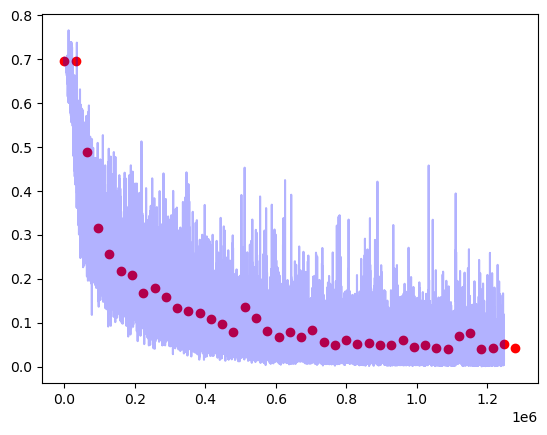

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue',alpha=0.3)
# print(len(test_counter))
#print(len(test_losses))
plt.scatter(test_counter, test_losses, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')

# CHECK THE CLASSIFICATION DECISIONS OF THE CNN

In [ ]:
with torch.no_grad():
    output = torch.sigmoid(net(example_data))

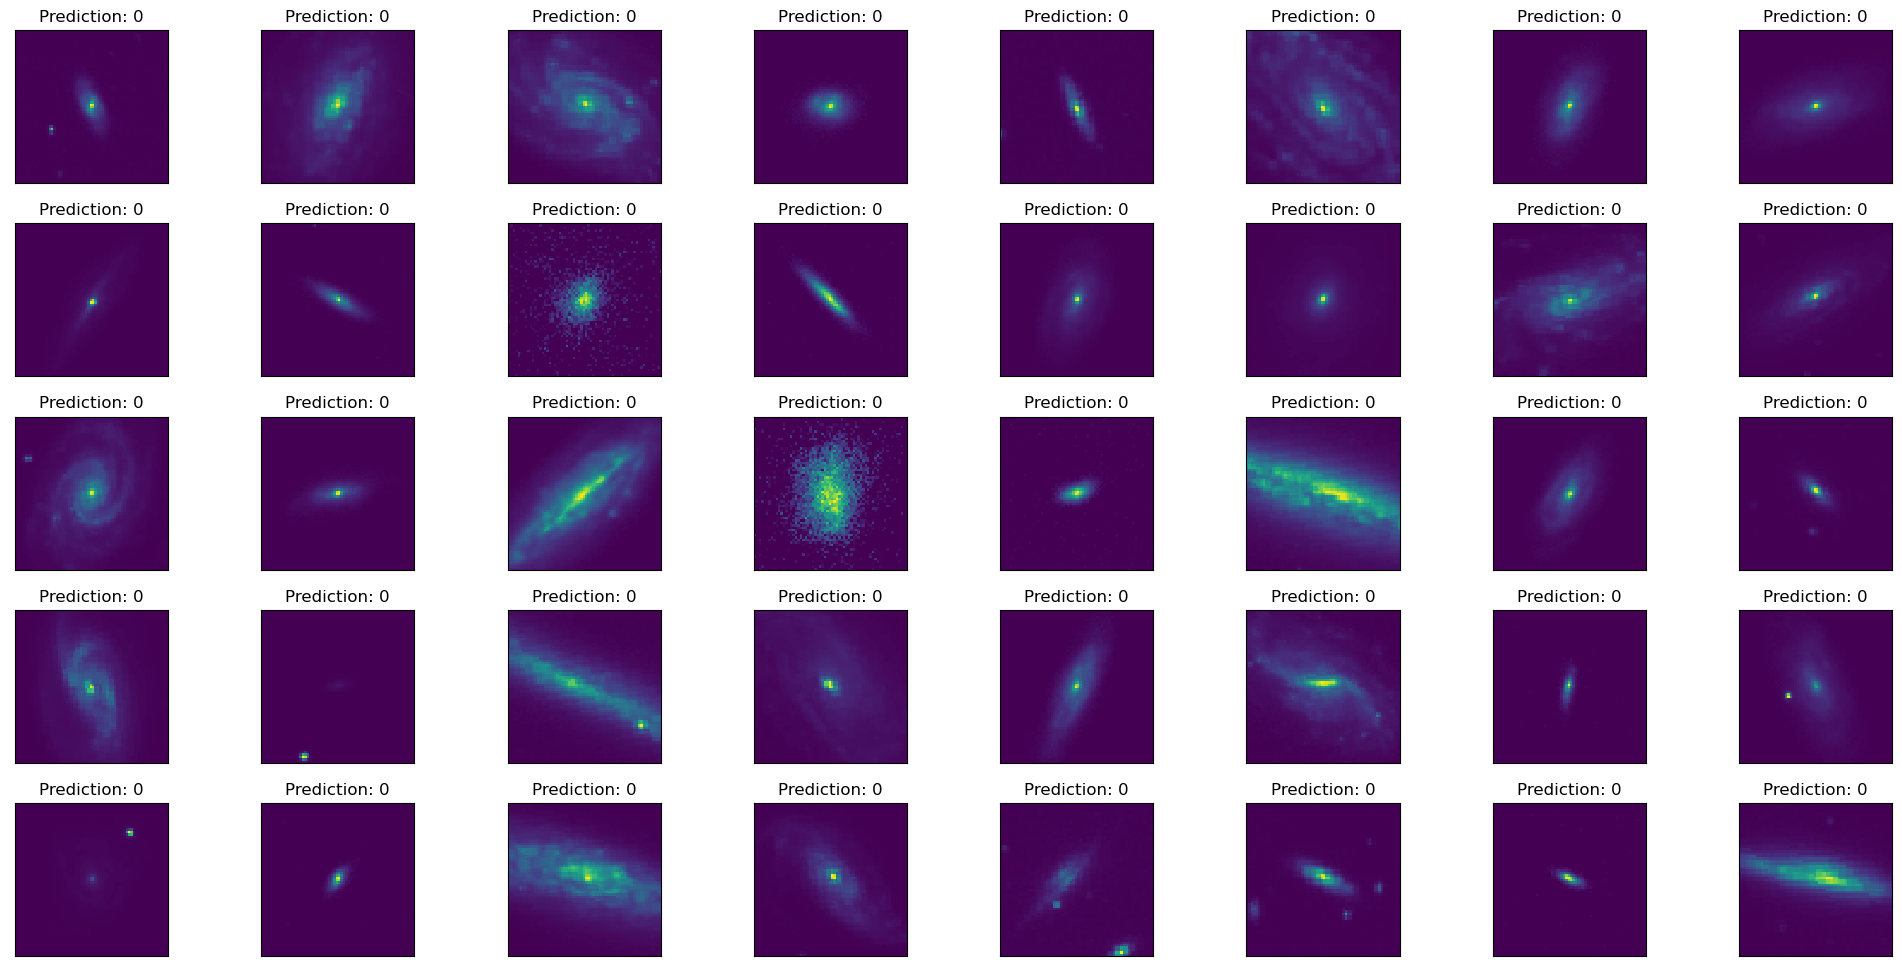

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i in range(40):
    plt.subplot(5,8,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

In [ ]:
torch.sigmoid(output)


tensor([[0.6138],
        [0.6201],
        [0.6163],
        [0.6180],
        [0.6154],
        [0.6183],
        [0.6150],
        [0.6227],
        [0.6196],
        [0.6139],
        [0.6175],
        [0.6153],
        [0.6207],
        [0.6162],
        [0.6122],
        [0.6202],
        [0.6216],
        [0.6177],
        [0.6179],
        [0.6151],
        [0.6206],
        [0.6140],
        [0.6206],
        [0.6137],
        [0.6187],
        [0.6168],
        [0.6137],
        [0.6143],
        [0.6144],
        [0.6187],
        [0.6160],
        [0.6162],
        [0.6145],
        [0.6179],
        [0.6154],
        [0.6165],
        [0.6172],
        [0.6167],
        [0.6111],
        [0.6207],
        [0.6201],
        [0.6201],
        [0.6189],
        [0.6172],
        [0.6134],
        [0.6193],
        [0.6140],
        [0.6158],
        [0.6139],
        [0.6174],
        [0.6207],
        [0.6109],
        [0.6147],
        [0.6119],
        [0.6145],
        [0

In [ ]:
x = torch.rand(100)


In [ ]:
x

tensor([0.9873, 0.1949, 0.0611, 0.0856, 0.5557, 0.6743, 0.7893, 0.8742, 0.8428,
        0.8301, 0.4512, 0.2115, 0.0655, 0.1301, 0.1555, 0.5425, 0.5618, 0.8469,
        0.4538, 0.7734, 0.1747, 0.8113, 0.4082, 0.9317, 0.7905, 0.6874, 0.6086,
        0.8424, 0.4348, 0.9967, 0.9171, 0.9692, 0.8348, 0.1703, 0.0704, 0.4481,
        0.0417, 0.2322, 0.2324, 0.8900, 0.0520, 0.6436, 0.9541, 0.7197, 0.0118,
        0.1904, 0.2823, 0.6629, 0.1923, 0.4303, 0.6465, 0.8154, 0.9049, 0.1592,
        0.1413, 0.1621, 0.5076, 0.1779, 0.4409, 0.3621, 0.9172, 0.9469, 0.3182,
        0.9937, 0.9451, 0.0988, 0.1092, 0.4804, 0.4262, 0.6575, 0.3377, 0.5769,
        0.2124, 0.0777, 0.5692, 0.1888, 0.5274, 0.1250, 0.3143, 0.5305, 0.0372,
        0.7564, 0.4254, 0.6423, 0.7633, 0.9087, 0.8470, 0.2436, 0.0552, 0.6789,
        0.8777, 0.5162, 0.2338, 0.8159, 0.9432, 0.5656, 0.7119, 0.9653, 0.1514,
        0.2461])

In [ ]:
x[x>0.5] = 0
#x[x<=0.5] = 1

In [ ]:
x

tensor([0.0000, 0.1949, 0.0611, 0.0856, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4512, 0.2115, 0.0655, 0.1301, 0.1555, 0.0000, 0.0000, 0.0000,
        0.4538, 0.0000, 0.1747, 0.0000, 0.4082, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.4348, 0.0000, 0.0000, 0.0000, 0.0000, 0.1703, 0.0704, 0.4481,
        0.0417, 0.2322, 0.2324, 0.0000, 0.0520, 0.0000, 0.0000, 0.0000, 0.0118,
        0.1904, 0.2823, 0.0000, 0.1923, 0.4303, 0.0000, 0.0000, 0.0000, 0.1592,
        0.1413, 0.1621, 0.0000, 0.1779, 0.4409, 0.3621, 0.0000, 0.0000, 0.3182,
        0.0000, 0.0000, 0.0988, 0.1092, 0.4804, 0.4262, 0.0000, 0.3377, 0.0000,
        0.2124, 0.0777, 0.0000, 0.1888, 0.0000, 0.1250, 0.3143, 0.0000, 0.0372,
        0.0000, 0.4254, 0.0000, 0.0000, 0.0000, 0.0000, 0.2436, 0.0552, 0.0000,
        0.0000, 0.0000, 0.2338, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1514,
        0.2461])

In [ ]:
len(x[x<=0.5])

0

In [ ]:
test_data[3000][1]

1